# Load dependencies

In [1]:
import pandas as pd
import numpy as np
from models import CellStateEncoder,CellStateDecoder,CellStateVAE
from evaluationUtils import pearson_r,r_square,pseudoAccuracy
from sklearn.metrics import silhouette_score,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy
from scipy.signal import savgol_filter
from scipy.spatial.distance import pdist,squareform
import torch
from matplotlib import pyplot as plt
import umap

from IPython.display import clear_output
import seaborn as sns
sns.set()

In [2]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

# Load Data

In [3]:
# Gex data 
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_HT29_A375.csv',index_col=0)
gene_size = len(cmap.columns)
sampleInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/a375_unpaired.csv',index_col=0)
sampleInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/ht29_unpaired.csv',index_col=0)
sampleInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/paired_a375_ht29.csv',index_col=0)
l1 = len(pd.concat((sampleInfo_1.sig_id,sampleInfo_paired['sig_id.x'])).drop_duplicates())
l2 = len(pd.concat((sampleInfo_2.sig_id,sampleInfo_paired['sig_id.y'])).drop_duplicates())
cmap = cmap.loc[pd.concat((sampleInfo_1.sig_id,sampleInfo_paired['sig_id.x'],
                            sampleInfo_2.sig_id,sampleInfo_paired['sig_id.y'])).drop_duplicates().reset_index(drop=True),
                 :].drop_duplicates()
cmap['cell'] = 0
cmap.iloc[0:l1,-1] = 1
cmap = cmap.sample(frac=1)
X = cmap.iloc[:,:-1].values
Y = cmap.iloc[:,-1].values

In [4]:
X = cmap.iloc[:,:-1].values
Y = cmap.iloc[:,-1].values

In [5]:
device = torch.device('cuda')

# Train all DCS

### Train master encoder

In [6]:
N = len(cmap)
master_encoder = CellStateEncoder(1024,gene_size,hidden_layers=[4096,2048]).to(device)
master_decoder = CellStateDecoder(1024,gene_size,hidden_layers=[2048,4096]).to(device)
master_autoencoder = CellStateVAE(master_encoder,master_decoder).to(device)
optimizer = torch.optim.Adam(master_autoencoder.parameters(), lr= 0.0001, weight_decay=0)
NUM_EPOCHS = 500
bs = 512

In [7]:
for e in range(0, NUM_EPOCHS):
    master_autoencoder.train()
    trainloader = getSamples(N, bs)
    for dataIndex in trainloader:
        optimizer.zero_grad()
        xin = torch.tensor(X[dataIndex,:]).float().to(device)
        z_latent , y_pred = master_autoencoder(xin)
        fitLoss = torch.mean(torch.sum((y_pred - xin)**2,dim=1))
        L1Loss = 1e-7 * torch.mean(torch.sum(torch.abs(z_latent),dim=1))
        loss = fitLoss + L1Loss
        
        loss.backward()

        optimizer.step()
        
        pearson = pearson_r(y_pred.detach().flatten(), xin.detach().flatten())
        r2 = r_square(y_pred.detach().flatten(), xin.detach().flatten())
        mse = torch.mean(torch.mean((y_pred.detach() - xin.detach())**2,dim=1))
        
        outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
        outString += ', r2={:.4f}'.format(r2.item())
        outString += ', pearson={:.4f}'.format(pearson.item())
        outString += ', MSE={:.4f}'.format(mse.item())
        outString += ', loss={:.4f}'.format(loss.item())
        print(outString)
        clear_output(wait=True)

Epoch=500/500, r2=-3.4369, pearson=0.4279, MSE=0.8828, loss=8903.4561


In [9]:
# torch.save(master_autoencoder,'../results/deepcellstate_results_10kgenes/alldata_master_autoencoder_withnoise_10k.pt')

In [6]:
master_autoencoder = torch.load('../results/deepcellstate_results_10kgenes/alldata_master_autoencoder_withnoise_10k.pt')

In [7]:
decoder_a375 = CellStateDecoder(1024,gene_size,[2048,4096]).to(device)
decoder_ht29 = CellStateDecoder(1024,gene_size,[2048,4096]).to(device)
master_encoder = CellStateEncoder(1024,gene_size,[4096,2048]).to(device)

In [8]:
master_encoder.load_state_dict(master_autoencoder.encoder.state_dict())
decoder_a375.load_state_dict(master_autoencoder.decoder.state_dict())
decoder_ht29.load_state_dict(master_autoencoder.decoder.state_dict())

<All keys matched successfully>

In [9]:
NUM_EPOCHS = 1000
#bs = 128
bs_a375 = 180
bs_ht29 = 156
bs_paired = 88

In [10]:
allParams = list(master_encoder.parameters()) +list(decoder_a375.parameters()) + list(decoder_ht29.parameters())
optimizer = torch.optim.Adam(allParams, lr= 0.0001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)

In [11]:
N_paired = len(sampleInfo_paired)
N_a375 = len(sampleInfo_1)
N_ht29 = len(sampleInfo_2)
N = N_a375
if N_ht29>N:
    N=N_ht29

In [6]:
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_HT29_A375.csv',index_col=0)
cmap = cmap.loc[pd.concat((sampleInfo_1.sig_id,sampleInfo_paired['sig_id.x'],
                            sampleInfo_2.sig_id,sampleInfo_paired['sig_id.y'])).drop_duplicates().reset_index(drop=True),
                 :].drop_duplicates()
cmap

,16,23,25,30,39,47,102,128,142,154,...,729230,729515,100129250,100131755,100132406,100287932,100289678,100507436,9142,26148
DOSBIO001_A375_24H:BRD-K72343629:10.1316,1.545521,1.061800,1.165320,-1.052685,-3.449826,0.503872,1.850187,-0.426328,0.004190,1.948446,...,-0.091040,0.040860,0.378187,1.264697,-0.450258,-1.153419,0.232950,-1.387834,0.104525,-0.515325
DOSBIO002_A375_24H:BRD-K22052171:9.97874,0.573862,-1.478506,1.284757,1.114560,-1.628030,0.559048,0.799478,0.675117,0.988028,-1.850497,...,-0.736037,-0.446497,0.646688,-0.098381,-0.202127,-1.297316,0.277845,-0.046932,-0.117402,-0.210667
DOSBIO002_A375_24H:BRD-K25379780:10.5212,0.468655,-0.864797,-0.182940,-0.529013,1.603291,1.815907,-0.188831,0.805886,1.100750,-1.278348,...,-0.739619,-0.218896,0.403286,-0.028610,0.200646,0.160801,0.141702,-0.175934,-0.910911,-1.190587
DOSBIO002_A375_24H:BRD-K87125912:9.98177,0.624088,-0.239281,-0.235216,0.951562,7.336524,4.183496,0.068398,-1.822858,-2.063225,-1.541112,...,1.396117,-0.174704,0.519222,0.669299,-0.323203,-1.514915,-0.961175,1.848807,-0.208447,0.279424
DOSBIO001_A375_24H:BRD-K70900504:10.0464,1.510834,2.235203,0.867541,-0.436479,-2.886851,0.172087,1.488347,-0.646825,-0.688189,1.123355,...,0.506248,-1.307817,0.301336,0.561701,-1.005974,0.426153,-0.177931,-0.194986,0.548976,1.016693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPC012_HT29_6H:BRD-K74761218-001-03-5:10,-1.650206,0.019022,-1.028554,0.209129,-1.245795,0.833030,0.778063,-0.895520,-1.206261,1.346442,...,-0.621593,0.945812,0.419918,-0.668789,0.460151,0.440341,-1.884926,1.830030,0.334797,-1.431227
CPC006_HT29_24H:BRD-A62182663-001-01-4:10,0.143746,-0.044304,0.296172,0.184163,-0.616859,-0.531261,3.590796,-1.901928,0.958495,0.427105,...,-0.905865,-1.424886,1.130776,-0.421499,0.438033,0.331161,-0.104879,0.451170,0.006299,0.782695
CPC013_HT29_6H:A15,-0.787285,-0.197107,-1.044924,1.059091,0.435514,-0.553575,-1.036044,-0.109397,-1.271592,1.218367,...,0.375502,0.215030,-0.617606,0.371418,-0.542508,0.826989,-1.606035,-0.034839,-0.181367,0.292102
REP.A022_HT29_24H:J01,0.253279,3.065412,0.041579,0.283965,-0.422361,0.300706,0.250005,-1.572236,0.559977,4.469641,...,1.470468,-0.962584,-0.246275,0.122734,0.893849,0.661904,-0.789807,-0.979607,0.519886,0.074205


In [ ]:
for e in range(0, NUM_EPOCHS):
    decoder_a375.train()
    decoder_ht29.train()
    master_encoder.train()
        
    trainloader_a375 = getSamples(N_a375, bs_a375)
    len_a375 = len(trainloader_a375)
    trainloader_ht29 = getSamples(N_ht29, bs_ht29)
    len_ht29 = len(trainloader_ht29)
    trainloader_paired = getSamples(N_paired, bs_paired)
    len_paired = len(trainloader_paired)

    lens = [len_a375,len_ht29,len_paired]
    maxLen = np.max(lens)

    if maxLen>lens[0]:
        trainloader_suppl = getSamples(N_a375, bs_a375)
        for jj in range(maxLen-lens[0]):
            trainloader_a375.insert(jj,trainloader_suppl[jj])
        
    if maxLen>lens[1]:
        trainloader_suppl = getSamples(N_ht29, bs_ht29)
        for jj in range(maxLen-lens[1]):
            trainloader_ht29.insert(jj,trainloader_suppl[jj])
        
    if maxLen>lens[2]:
        trainloader_suppl = getSamples(N_paired, bs_paired)
        for jj in range(maxLen-lens[2]):
            trainloader_paired.insert(jj,trainloader_suppl[jj])
    #for dataIndex in trainloader:
    for j in range(maxLen):
        dataIndex_a375 = trainloader_a375[j]
        dataIndex_ht29 = trainloader_ht29[j]
        dataIndex_paired = trainloader_paired[j]
            
        df_pairs = sampleInfo_paired.iloc[dataIndex_paired,:]
        df_a375 = sampleInfo_1.iloc[dataIndex_a375,:]
        df_ht29 = sampleInfo_2.iloc[dataIndex_ht29,:]
        paired_inds = len(df_pairs)
            
        optimizer.zero_grad()
        X_a375 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
                                              cmap.loc[df_a375.sig_id].values))).float().to(device)
        X_ht29 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
                                              cmap.loc[df_ht29.sig_id].values))).float().to(device)
            
        z_a375 , xd_a375 = master_encoder(X_a375)
        y_pred_a375 = decoder_a375(z_a375,xd_a375)
        fitLoss_a375 = torch.mean(torch.sum((y_pred_a375 - X_a375)**2,dim=1)) #+ compute_mmd(true_samples_a375,z_a375)
        L1Loss_a375 = 1e-7 * torch.mean(torch.sum(torch.abs(z_a375),dim=1)) 
        loss_a375 = fitLoss_a375 + L1Loss_a375
        
        z_ht29,xd_ht29 = master_encoder(X_ht29)
        y_pred_ht29 = decoder_ht29(z_ht29,xd_ht29)
        fitLoss_ht29 = torch.mean(torch.sum((y_pred_ht29 - X_ht29)**2,dim=1)) #+ compute_mmd(true_samples_ht29,z_ht29)
        L1Loss_ht29 = 1e-7 * torch.mean(torch.sum(torch.abs(z_ht29),dim=1)) 
        loss_ht29 = fitLoss_ht29 + L1Loss_ht29
        
        loss = loss_a375 + loss_ht29 #+ silimalityLoss + directLoss
        loss.backward()
        optimizer.step()
        
        pearson_a375 = pearson_r(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
        r2_a375 = r_square(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
        mse_a375 = torch.mean(torch.mean((y_pred_a375.detach() - X_a375.detach())**2,dim=1))
        
        pearson_ht29 = pearson_r(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
        r2_ht29 = r_square(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
        mse_ht29 = torch.mean(torch.mean((y_pred_ht29.detach() - X_ht29.detach())**2,dim=1))
        
        outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
        outString += ', r2_a375={:.4f}'.format(r2_a375.item())
        outString += ', pearson_a375={:.4f}'.format(pearson_a375.item())
        outString += ', MSE_a375={:.4f}'.format(mse_a375.item())
        outString += ', r2_ht29={:.4f}'.format(r2_ht29.item())
        outString += ', pearson_ht29={:.4f}'.format(pearson_ht29.item())
        outString += ', MSE_ht29={:.4f}'.format(mse_ht29.item())
        outString += ', loss={:.4f}'.format(loss.item())
    if e % 100 == 0:    
        print(outString)
    #clear_output(wait=True)
    scheduler.step()
print(outString)

In [14]:
# torch.save(master_encoder,'../results/deepcellstate_results_10kgenes/alldata_master_encoder_withnoise_10k.pt')
# torch.save(decoder_a375,'../results/deepcellstate_results_10kgenes/alldata_decoder_a375_withnoise_10k.pt')
# torch.save(decoder_ht29,'../results/deepcellstate_results_10kgenes/alldata_decoder_ht29_withnoise_10k.pt')

In [6]:
master_encoder = torch.load('../results/deepcellstate_results_10kgenes/alldata_master_encoder_withnoise_10k.pt').to(device)
decoder_a375 = torch.load('../results/deepcellstate_results_10kgenes/alldata_decoder_a375_withnoise_10k.pt').to(device)
decoder_ht29 = torch.load('../results/deepcellstate_results_10kgenes/alldata_decoder_ht29_withnoise_10k.pt').to(device)

In [7]:
decoder_a375.eval()
decoder_ht29.eval()
master_encoder.eval()

CellStateEncoder(
  (linear_layers): ModuleList(
    (0): Linear(in_features=10086, out_features=4096, bias=True)
    (1): Linear(in_features=4096, out_features=2048, bias=True)
  )
  (linear_latent): Linear(in_features=2048, out_features=1024, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
X_a375 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.x']].values,
                                      cmap.loc[sampleInfo_1.sig_id].values))).float().to(device)
X_ht29 = torch.tensor(np.concatenate((cmap.loc[sampleInfo_paired['sig_id.y']].values,
                                      cmap.loc[sampleInfo_2.sig_id].values))).float().to(device)
            
z_a375 , xd_a375 = master_encoder(X_a375)
y_pred_a375 = decoder_a375(z_a375,xd_a375)

z_ht29,xd_ht29 = master_encoder(X_ht29)
y_pred_ht29 = decoder_ht29(z_ht29,xd_ht29)

pearson_a375 = pearson_r(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
pearson_ht29 = pearson_r(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())

print(pearson_a375)
print(pearson_ht29)

tensor(0.9989, device='cuda:0')
tensor(0.9989, device='cuda:0')


In [14]:
embs_a375 = pd.DataFrame(z_a375.detach().cpu().numpy())
embs_a375.index = list(sampleInfo_paired['sig_id.x']) + list(sampleInfo_1.sig_id)
embs_a375.columns = ['z_'+str(i) for i in range(embs_a375.shape[1])]
embs_a375.to_csv('../results/deepcellstate_results_10kgenes/allembs_a375_dcs_withnoise_10k.csv')

In [15]:
embs_ht29 = pd.DataFrame(z_ht29.detach().cpu().numpy())
embs_ht29.index = list(sampleInfo_paired['sig_id.y']) + list(sampleInfo_2.sig_id)
embs_ht29.columns = ['z_'+str(i) for i in range(embs_ht29.shape[1])]
embs_ht29.to_csv('../results/deepcellstate_results_10kgenes/allembs_ht29_dcs_withnoise_10k.csv')

# Train classifier

In [7]:
embs1 = pd.read_csv('../results/deepcellstate_results_10kgenes/allembs_a375_dcs_withnoise_10k.csv',index_col=0)
emb1 = embs1.drop_duplicates()
emb1['cell'] = 'A375'
emb2 = pd.read_csv('../results/deepcellstate_results_10kgenes/allembs_ht29_dcs_withnoise_10k.csv',index_col=0)
emb2 = emb2.drop_duplicates()
emb2['cell'] = 'HT29'

all_embs = pd.concat((emb1,emb2),axis=0)
all_embs = all_embs.sample(frac=1)
all_embs.cell = 1*(all_embs.cell=='A375')
all_embs

<ipython-input-7-821a98a8e412>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb1['cell'] = 'A375'


,z_0,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,...,z_1015,z_1016,z_1017,z_1018,z_1019,z_1020,z_1021,z_1022,z_1023,cell
PBIOA018_HT29_24H:O15,-0.884147,-1.038274,-0.388744,1.389728,-3.146408,0.250561,-1.807078,-0.557470,1.634527,-0.291838,...,1.066601,-0.005466,0.399963,1.255220,1.725748,-0.009871,-0.721076,-0.886286,-0.844054,0
REP.A027_A375_24H:P07,-0.093448,0.042499,-1.945417,3.095254,-2.143601,-0.395196,-2.273413,-1.761036,0.180572,-0.913526,...,-0.083035,-1.742336,-0.078667,-2.283925,2.895148,-1.706993,0.529490,-0.633321,0.577388,1
CPC006_HT29_24H:BRD-K53414658-001-01-7:10,0.728420,-0.840370,-0.412064,0.247263,-2.088750,-1.452462,-1.262084,-0.704561,0.663077,-0.182234,...,-1.342367,-0.461317,0.894991,-1.092073,1.763130,-1.932276,-0.047509,-0.516944,-2.235938,0
PBIOA020_A375_24H:O07,-0.859764,-1.136204,-1.396211,3.222661,-1.858990,0.294057,-4.615648,-0.380652,-1.799727,1.185301,...,-0.213359,-0.753354,1.173923,-1.611985,0.149997,1.852467,-0.940308,-2.006469,1.778580,1
CPC013_HT29_6H:H22,0.732641,-1.334340,2.101893,1.896522,-2.458691,-0.212187,-2.907527,-0.520804,-0.246018,-1.314029,...,0.329381,0.485671,-0.535701,-0.229986,-0.562690,-0.431944,-0.073277,0.559170,0.432479,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPC007_A375_24H:BRD-A54194844-001-02-9:10,-1.741952,0.705205,-0.557317,1.233272,-2.405213,-0.554395,-3.532829,0.909928,-1.073713,0.272761,...,-0.439473,1.350881,1.902814,0.036844,2.798712,1.061599,-0.393180,-1.241849,-1.298498,1
CPC018_A375_6H:BRD-K17497770-001-01-0:10,0.446736,-0.810077,0.514531,-0.075010,-1.637304,-1.465496,-2.414805,-0.844524,1.290653,1.897606,...,1.282764,0.732187,0.525134,0.625747,1.114405,1.381275,-0.867608,0.215298,-0.493970,1
CPC005_HT29_24H:BRD-K49294207-300-01-2:10,1.469819,-1.379639,-0.886603,-0.003919,-1.042079,0.337831,-1.159749,-1.208429,0.199160,-0.379934,...,-0.837077,-0.854619,0.604640,1.188955,0.586874,-1.916238,-0.955294,-0.169928,-1.269765,0
REP.A024_A375_24H:I01,-0.162926,-0.471143,-0.066781,0.608648,0.074646,-0.672405,-3.071716,0.712455,0.102636,1.440274,...,-0.833570,0.764877,-0.484256,1.034291,1.097000,1.886707,-0.720489,0.454812,0.445356,1


In [6]:
class CellBinaryClassifier(torch.nn.Module):
    def __init__(self,in_channel,hidden_layers,drop_in=0.5,drop=0.2,bn=0.6,bias=True,dtype=None):
        super(CellBinaryClassifier, self).__init__()
        self.drop_in = drop_in
        self.num_hidden_layers = len(hidden_layers)
        self.bias = bias
        self.bn = torch.nn.ModuleList()
        self.linear_layers = torch.nn.ModuleList()
        self.dropouts = torch.nn.ModuleList()
        self.activations = torch.nn.ModuleList()
        self.linear_layers.append(torch.nn.Linear(in_channel, hidden_layers[0], bias=bias,dtype=dtype))
        self.bn.append(torch.nn.BatchNorm1d(num_features=hidden_layers[0], momentum=bn,dtype=dtype))
        self.dropouts.append(torch.nn.Dropout(drop))
        self.activations.append(torch.nn.ReLU())
        for i in range(1, len(hidden_layers)):
            self.linear_layers.append(torch.nn.Linear(hidden_layers[i - 1], hidden_layers[i], 
                                                      bias=bias,dtype=dtype))
            self.bn.append(torch.nn.BatchNorm1d(num_features=hidden_layers[i], momentum=bn,
                                                dtype=dtype))
            self.dropouts.append(torch.nn.Dropout(drop))
            self.activations.append(torch.nn.ReLU())
        self.out_linear = torch.nn.Linear(hidden_layers[i],2,bias=bias,dtype=dtype)
        self.softmax = torch.nn.Softmax(dim=1)
        if self.drop_in>0:
            self.InputDrop = torch.nn.Dropout(self.drop_in)
        
        self.init_emb()

    def init_emb(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
    
    def forward(self,x):
        if self.drop_in>0:
            x = self.InputDrop(x)
        for i in range(self.num_hidden_layers):
            x = self.linear_layers[i](x)
            x = self.bn[i](x)
            x = self.activations[i](x)
            x = self.dropouts[i](x)
            
        return self.softmax(self.out_linear(x))
    
    def L2Regularization(self, L2):

        weightLoss = 0.
        biasLoss = 0.
        for i in range(self.num_hidden_layers):
            weightLoss = weightLoss + L2 * torch.sum((self.linear_layers[i].weight)**2)
            if self.bias==True:
                biasLoss = biasLoss + L2 * torch.sum((self.linear_layers[i].bias)**2)
        L2Loss = biasLoss + weightLoss
        return(L2Loss)

In [7]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

In [8]:
# model = CellBinaryClassifier(in_channel=1024,hidden_layers=[512,256,128,64,32]).to(device)
criterion = torch.nn.CrossEntropyLoss()
bs=128
k_folds=10
NUM_EPOCHS=1000
#N = Y_train.size
kfold=KFold(n_splits=k_folds,shuffle=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
bs_1 = 178
bs_2 =  154
bs_paired =  90

Fold=0, Epoch=1/1000, L2 Loss=10.5018, Entropy Loss=0.6907, loss=11.1925, Accuracy=0.5952, F1 score=0.5143
Fold=0, Epoch=51/1000, L2 Loss=0.2819, Entropy Loss=0.5365, loss=0.8184, Accuracy=0.7619, F1 score=0.7727
Fold=0, Epoch=101/1000, L2 Loss=0.2738, Entropy Loss=0.3569, loss=0.6307, Accuracy=0.9524, F1 score=0.9524
Fold=0, Epoch=151/1000, L2 Loss=0.2620, Entropy Loss=0.3662, loss=0.6283, Accuracy=0.9524, F1 score=0.9545
Fold=0, Epoch=201/1000, L2 Loss=0.2825, Entropy Loss=0.3695, loss=0.6520, Accuracy=0.9524, F1 score=0.9524
Fold=0, Epoch=251/1000, L2 Loss=0.3265, Entropy Loss=0.3796, loss=0.7061, Accuracy=0.9286, F1 score=0.9302
Fold=0, Epoch=301/1000, L2 Loss=0.2687, Entropy Loss=0.4109, loss=0.6795, Accuracy=0.8810, F1 score=0.8718
Fold=0, Epoch=351/1000, L2 Loss=0.3024, Entropy Loss=0.4307, loss=0.7331, Accuracy=0.8571, F1 score=0.8636
Fold=0, Epoch=401/1000, L2 Loss=0.3153, Entropy Loss=0.3961, loss=0.7114, Accuracy=0.9286, F1 score=0.9268
Fold=0, Epoch=451/1000, L2 Loss=0.2667

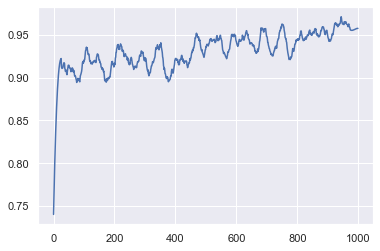

Fold=1, Epoch=1/1000, L2 Loss=10.5299, Entropy Loss=0.6783, loss=11.2082, Accuracy=0.5238, F1 score=0.6000
Fold=1, Epoch=51/1000, L2 Loss=0.2510, Entropy Loss=0.3855, loss=0.6365, Accuracy=0.9048, F1 score=0.9091
Fold=1, Epoch=101/1000, L2 Loss=0.2790, Entropy Loss=0.3256, loss=0.6046, Accuracy=1.0000, F1 score=1.0000
Fold=1, Epoch=151/1000, L2 Loss=0.3178, Entropy Loss=0.3280, loss=0.6459, Accuracy=1.0000, F1 score=1.0000
Fold=1, Epoch=201/1000, L2 Loss=0.3165, Entropy Loss=0.4057, loss=0.7222, Accuracy=0.9048, F1 score=0.9048
Fold=1, Epoch=251/1000, L2 Loss=0.3163, Entropy Loss=0.3860, loss=0.7022, Accuracy=0.9048, F1 score=0.9048
Fold=1, Epoch=301/1000, L2 Loss=0.3291, Entropy Loss=0.3468, loss=0.6759, Accuracy=0.9762, F1 score=0.9767
Fold=1, Epoch=351/1000, L2 Loss=0.2713, Entropy Loss=0.3390, loss=0.6103, Accuracy=0.9762, F1 score=0.9756
Fold=1, Epoch=401/1000, L2 Loss=0.2603, Entropy Loss=0.4724, loss=0.7328, Accuracy=0.8333, F1 score=0.8372
Fold=1, Epoch=451/1000, L2 Loss=0.2931

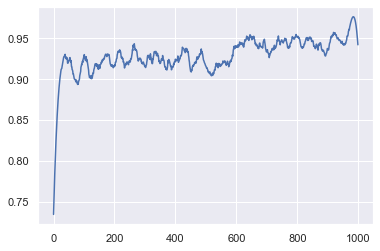

Fold=2, Epoch=1/1000, L2 Loss=10.5076, Entropy Loss=0.6825, loss=11.1901, Accuracy=0.5476, F1 score=0.5957
Fold=2, Epoch=51/1000, L2 Loss=0.2781, Entropy Loss=0.5085, loss=0.7866, Accuracy=0.7857, F1 score=0.7907
Fold=2, Epoch=101/1000, L2 Loss=0.2667, Entropy Loss=0.3547, loss=0.6214, Accuracy=0.9524, F1 score=0.9500
Fold=2, Epoch=151/1000, L2 Loss=0.3204, Entropy Loss=0.4272, loss=0.7477, Accuracy=0.8810, F1 score=0.8837
Fold=2, Epoch=201/1000, L2 Loss=0.3516, Entropy Loss=0.3926, loss=0.7442, Accuracy=0.9286, F1 score=0.9268
Fold=2, Epoch=251/1000, L2 Loss=0.3496, Entropy Loss=0.4133, loss=0.7630, Accuracy=0.8810, F1 score=0.8780
Fold=2, Epoch=301/1000, L2 Loss=0.4019, Entropy Loss=0.3994, loss=0.8012, Accuracy=0.9048, F1 score=0.9048
Fold=2, Epoch=351/1000, L2 Loss=0.3281, Entropy Loss=0.3896, loss=0.7177, Accuracy=0.8810, F1 score=0.8837
Fold=2, Epoch=401/1000, L2 Loss=0.2884, Entropy Loss=0.3774, loss=0.6658, Accuracy=0.9286, F1 score=0.9268
Fold=2, Epoch=451/1000, L2 Loss=0.2474

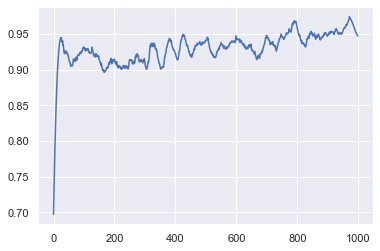

Fold=3, Epoch=1/1000, L2 Loss=10.5240, Entropy Loss=0.6286, loss=11.1526, Accuracy=0.6667, F1 score=0.6316
Fold=3, Epoch=51/1000, L2 Loss=0.2941, Entropy Loss=0.4228, loss=0.7169, Accuracy=0.8810, F1 score=0.8889
Fold=3, Epoch=101/1000, L2 Loss=0.3156, Entropy Loss=0.3775, loss=0.6931, Accuracy=0.9286, F1 score=0.9302
Fold=3, Epoch=151/1000, L2 Loss=0.2724, Entropy Loss=0.4156, loss=0.6880, Accuracy=0.8810, F1 score=0.8780
Fold=3, Epoch=201/1000, L2 Loss=0.2842, Entropy Loss=0.3536, loss=0.6378, Accuracy=0.9762, F1 score=0.9756
Fold=3, Epoch=251/1000, L2 Loss=0.3264, Entropy Loss=0.4315, loss=0.7579, Accuracy=0.8810, F1 score=0.8780
Fold=3, Epoch=301/1000, L2 Loss=0.2758, Entropy Loss=0.4351, loss=0.7109, Accuracy=0.8571, F1 score=0.8571
Fold=3, Epoch=351/1000, L2 Loss=0.2905, Entropy Loss=0.3651, loss=0.6555, Accuracy=0.9524, F1 score=0.9500
Fold=3, Epoch=401/1000, L2 Loss=0.2835, Entropy Loss=0.3444, loss=0.6279, Accuracy=0.9762, F1 score=0.9756
Fold=3, Epoch=451/1000, L2 Loss=0.2474

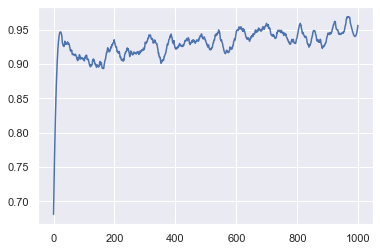

Fold=4, Epoch=1/1000, L2 Loss=10.5411, Entropy Loss=0.6462, loss=11.1873, Accuracy=0.6905, F1 score=0.7111
Fold=4, Epoch=51/1000, L2 Loss=0.2857, Entropy Loss=0.4295, loss=0.7152, Accuracy=0.8810, F1 score=0.8889
Fold=4, Epoch=101/1000, L2 Loss=0.2975, Entropy Loss=0.4419, loss=0.7395, Accuracy=0.8571, F1 score=0.8571
Fold=4, Epoch=151/1000, L2 Loss=0.2768, Entropy Loss=0.3416, loss=0.6184, Accuracy=0.9762, F1 score=0.9756
Fold=4, Epoch=201/1000, L2 Loss=0.3039, Entropy Loss=0.4123, loss=0.7162, Accuracy=0.9048, F1 score=0.9000
Fold=4, Epoch=251/1000, L2 Loss=0.2892, Entropy Loss=0.3783, loss=0.6675, Accuracy=0.9524, F1 score=0.9545
Fold=4, Epoch=301/1000, L2 Loss=0.3592, Entropy Loss=0.3413, loss=0.7005, Accuracy=0.9762, F1 score=0.9756
Fold=4, Epoch=351/1000, L2 Loss=0.2675, Entropy Loss=0.3832, loss=0.6507, Accuracy=0.9048, F1 score=0.9130
Fold=4, Epoch=401/1000, L2 Loss=0.2629, Entropy Loss=0.3791, loss=0.6420, Accuracy=0.9286, F1 score=0.9302
Fold=4, Epoch=451/1000, L2 Loss=0.2839

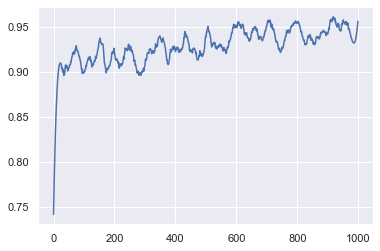

Fold=5, Epoch=1/1000, L2 Loss=10.4511, Entropy Loss=0.6686, loss=11.1196, Accuracy=0.5714, F1 score=0.4706
Fold=5, Epoch=51/1000, L2 Loss=0.2709, Entropy Loss=0.4143, loss=0.6852, Accuracy=0.8810, F1 score=0.8837
Fold=5, Epoch=101/1000, L2 Loss=0.2489, Entropy Loss=0.4041, loss=0.6530, Accuracy=0.9048, F1 score=0.9048
Fold=5, Epoch=151/1000, L2 Loss=0.2615, Entropy Loss=0.3886, loss=0.6501, Accuracy=0.9286, F1 score=0.9268
Fold=5, Epoch=201/1000, L2 Loss=0.3240, Entropy Loss=0.4586, loss=0.7825, Accuracy=0.8571, F1 score=0.8636
Fold=5, Epoch=251/1000, L2 Loss=0.2682, Entropy Loss=0.4237, loss=0.6918, Accuracy=0.9048, F1 score=0.9091
Fold=5, Epoch=301/1000, L2 Loss=0.3244, Entropy Loss=0.3961, loss=0.7204, Accuracy=0.9048, F1 score=0.9091
Fold=5, Epoch=351/1000, L2 Loss=0.3173, Entropy Loss=0.4237, loss=0.7411, Accuracy=0.9048, F1 score=0.9000
Fold=5, Epoch=401/1000, L2 Loss=0.2202, Entropy Loss=0.3542, loss=0.5743, Accuracy=0.9524, F1 score=0.9524
Fold=5, Epoch=451/1000, L2 Loss=0.3106

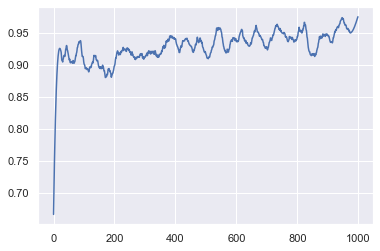

Fold=6, Epoch=1/1000, L2 Loss=10.4227, Entropy Loss=0.6231, loss=11.0459, Accuracy=0.5714, F1 score=0.6667
Fold=6, Epoch=51/1000, L2 Loss=0.2962, Entropy Loss=0.3754, loss=0.6716, Accuracy=0.9286, F1 score=0.9333
Fold=6, Epoch=101/1000, L2 Loss=0.3031, Entropy Loss=0.3902, loss=0.6933, Accuracy=0.9048, F1 score=0.9091
Fold=6, Epoch=151/1000, L2 Loss=0.2830, Entropy Loss=0.4131, loss=0.6961, Accuracy=0.8810, F1 score=0.8718
Fold=6, Epoch=201/1000, L2 Loss=0.2926, Entropy Loss=0.3828, loss=0.6754, Accuracy=0.9286, F1 score=0.9302
Fold=6, Epoch=251/1000, L2 Loss=0.3496, Entropy Loss=0.3960, loss=0.7455, Accuracy=0.9286, F1 score=0.9268
Fold=6, Epoch=301/1000, L2 Loss=0.3912, Entropy Loss=0.4381, loss=0.8293, Accuracy=0.8571, F1 score=0.8636
Fold=6, Epoch=351/1000, L2 Loss=0.2682, Entropy Loss=0.3724, loss=0.6406, Accuracy=0.9286, F1 score=0.9302
Fold=6, Epoch=401/1000, L2 Loss=0.2542, Entropy Loss=0.4545, loss=0.7087, Accuracy=0.8571, F1 score=0.8421
Fold=6, Epoch=451/1000, L2 Loss=0.2995

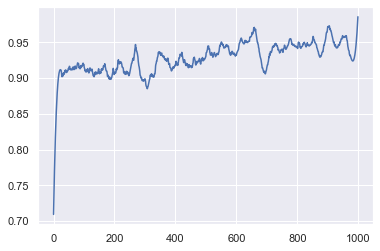

Fold=7, Epoch=1/1000, L2 Loss=10.5380, Entropy Loss=0.6246, loss=11.1626, Accuracy=0.6667, F1 score=0.7083
Fold=7, Epoch=51/1000, L2 Loss=0.3384, Entropy Loss=0.4535, loss=0.7918, Accuracy=0.8571, F1 score=0.8636
Fold=7, Epoch=101/1000, L2 Loss=0.3329, Entropy Loss=0.4420, loss=0.7750, Accuracy=0.8571, F1 score=0.8571
Fold=7, Epoch=151/1000, L2 Loss=0.3209, Entropy Loss=0.3782, loss=0.6991, Accuracy=0.9286, F1 score=0.9302
Fold=7, Epoch=201/1000, L2 Loss=0.3111, Entropy Loss=0.4810, loss=0.7921, Accuracy=0.8095, F1 score=0.8095
Fold=7, Epoch=251/1000, L2 Loss=0.3343, Entropy Loss=0.3662, loss=0.7004, Accuracy=0.9286, F1 score=0.9268
Fold=7, Epoch=301/1000, L2 Loss=0.3296, Entropy Loss=0.3884, loss=0.7181, Accuracy=0.9286, F1 score=0.9268
Fold=7, Epoch=351/1000, L2 Loss=0.3041, Entropy Loss=0.3550, loss=0.6592, Accuracy=0.9524, F1 score=0.9545
Fold=7, Epoch=401/1000, L2 Loss=0.3056, Entropy Loss=0.3944, loss=0.7001, Accuracy=0.9286, F1 score=0.9268
Fold=7, Epoch=451/1000, L2 Loss=0.2504

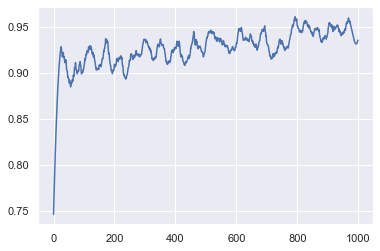

Fold=8, Epoch=1/1000, L2 Loss=10.4986, Entropy Loss=0.6774, loss=11.1760, Accuracy=0.5952, F1 score=0.5143
Fold=8, Epoch=51/1000, L2 Loss=0.2486, Entropy Loss=0.4462, loss=0.6948, Accuracy=0.8571, F1 score=0.8636
Fold=8, Epoch=101/1000, L2 Loss=0.2469, Entropy Loss=0.4585, loss=0.7054, Accuracy=0.8571, F1 score=0.8500
Fold=8, Epoch=151/1000, L2 Loss=0.2729, Entropy Loss=0.3441, loss=0.6170, Accuracy=0.9762, F1 score=0.9756
Fold=8, Epoch=201/1000, L2 Loss=0.3554, Entropy Loss=0.3635, loss=0.7190, Accuracy=0.9524, F1 score=0.9524
Fold=8, Epoch=251/1000, L2 Loss=0.3423, Entropy Loss=0.3802, loss=0.7225, Accuracy=0.9286, F1 score=0.9302
Fold=8, Epoch=301/1000, L2 Loss=0.3353, Entropy Loss=0.3885, loss=0.7238, Accuracy=0.9286, F1 score=0.9333
Fold=8, Epoch=351/1000, L2 Loss=0.2579, Entropy Loss=0.3683, loss=0.6261, Accuracy=0.9524, F1 score=0.9524
Fold=8, Epoch=401/1000, L2 Loss=0.2624, Entropy Loss=0.4043, loss=0.6667, Accuracy=0.9048, F1 score=0.9048
Fold=8, Epoch=451/1000, L2 Loss=0.3483

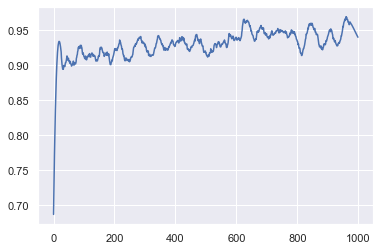

Fold=9, Epoch=1/1000, L2 Loss=10.5011, Entropy Loss=0.7040, loss=11.2050, Accuracy=0.5476, F1 score=0.5957
Fold=9, Epoch=51/1000, L2 Loss=0.2972, Entropy Loss=0.3924, loss=0.6896, Accuracy=0.9286, F1 score=0.9302
Fold=9, Epoch=101/1000, L2 Loss=0.2730, Entropy Loss=0.4534, loss=0.7264, Accuracy=0.8571, F1 score=0.8571
Fold=9, Epoch=151/1000, L2 Loss=0.3029, Entropy Loss=0.4314, loss=0.7343, Accuracy=0.8810, F1 score=0.8780
Fold=9, Epoch=201/1000, L2 Loss=0.2670, Entropy Loss=0.3381, loss=0.6051, Accuracy=0.9762, F1 score=0.9756
Fold=9, Epoch=251/1000, L2 Loss=0.3546, Entropy Loss=0.4074, loss=0.7620, Accuracy=0.9048, F1 score=0.9091
Fold=9, Epoch=301/1000, L2 Loss=0.2835, Entropy Loss=0.3865, loss=0.6701, Accuracy=0.9286, F1 score=0.9333
Fold=9, Epoch=351/1000, L2 Loss=0.3081, Entropy Loss=0.3764, loss=0.6844, Accuracy=0.9286, F1 score=0.9302
Fold=9, Epoch=401/1000, L2 Loss=0.3236, Entropy Loss=0.3626, loss=0.6862, Accuracy=0.9524, F1 score=0.9500
Fold=9, Epoch=451/1000, L2 Loss=0.2884

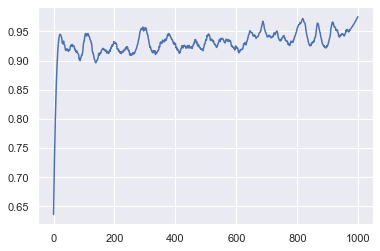

In [12]:
valF1 = []
valAcc = []
valPrec = []
valRec = []
#for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):
for fold in range(10):    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%fold,index_col=0)
    trainInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%fold,index_col=0)
    trainInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%fold,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%fold,index_col=0)
    valInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%fold,index_col=0)
    valInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%fold,index_col=0)
    
    #xtrain,ytrain = dataset[train_idx]
    #xtest,ytest = dataset[test_idx]
    #N = ytrain.shape[0]
    N_paired = len(trainInfo_paired)
    N_1 = len(trainInfo_1)
    N_2 = len(trainInfo_2)
    N = N_1
    if N_2>N:
        N=N_2
    model = CellBinaryClassifier(in_channel=1024,hidden_layers=[512,256,128],drop_in=0.5,drop=0.2).to(device)
    #model = CellBinaryClassifier(in_channel=gene_size,hidden_layers=[2048,4096,1024,512,256,128],drop_in=0.5,drop=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=300,
                                                gamma=0.8)
    trainAcc = []
    for e in range(NUM_EPOCHS):
        model.train()
        #trainloader = getSamples(N, bs)
        trainloader_1 = getSamples(N_1, bs_1)
        len_1 = len(trainloader_1)
        trainloader_2 = getSamples(N_2, bs_2)
        len_2 = len(trainloader_2)
        trainloader_paired = getSamples(N_paired, bs_paired)
        len_paired = len(trainloader_paired)
        lens = [len_1,len_2,len_paired]
        maxLen = np.max(lens)
        if maxLen>lens[0]:
            trainloader_suppl = getSamples(N_1, bs_1)
            for jj in range(maxLen-lens[0]):
                trainloader_1.insert(jj,trainloader_suppl[jj])
        if maxLen>lens[1]:
            trainloader_suppl = getSamples(N_2, bs_2)
            for jj in range(maxLen-lens[1]):
                trainloader_2.insert(jj,trainloader_suppl[jj])
        if maxLen>lens[2]:
            trainloader_suppl = getSamples(N_paired, bs_paired)
            for jj in range(maxLen-lens[2]):
                trainloader_paired.insert(jj,trainloader_suppl[jj])
        
        #for dataIndex in trainloader:
        for j in range(maxLen):
            dataIndex_1 = trainloader_1[j]
            dataIndex_2 = trainloader_2[j]
            dataIndex_paired = trainloader_paired[j]
            
            df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
            df_1 = trainInfo_1.iloc[dataIndex_1,:]
            df_2 = trainInfo_2.iloc[dataIndex_2,:]
            paired_inds = len(df_pairs)
            
            #X_1 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x'],cmap.columns!='cell'].values,
            #                                     cmap.loc[df_1.sig_id,cmap.columns!='cell'].values))).float().detach()
            #X_2 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y'],cmap.columns!='cell'].values,
            #                                     cmap.loc[df_2.sig_id,cmap.columns!='cell'].values))).float().detach()
            
            X_1 = torch.tensor(np.concatenate((all_embs.loc[df_pairs['sig_id.x'],all_embs.columns!='cell'].values,
                                                 all_embs.loc[df_1.sig_id,all_embs.columns!='cell'].values))).float().detach()
            X_2 = torch.tensor(np.concatenate((all_embs.loc[df_pairs['sig_id.y'],all_embs.columns!='cell'].values,
                                                 all_embs.loc[df_2.sig_id,all_embs.columns!='cell'].values))).float().detach()
            
            dataIn = torch.cat((X_1,X_2),0).detach().to(device)
            dataOut = torch.cat((torch.ones(X_1.shape[0]),torch.zeros(X_2.shape[0])),0).long()
            
            optimizer.zero_grad()
            #dataIn = xtrain[dataIndex].to(device)
            #dataOut = ytrain[dataIndex].to(device)
            out = model(dataIn)
            L2Loss = model.L2Regularization(1e-2)
            loss = criterion(out, dataOut.to(device)) + L2Loss
            
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(out, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(dataOut.cpu(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            acc = (tp+tn)/predicted.size
            f1 = 2*tp/(2*tp+fp+fn)
        if e%50==0:
            outString = 'Fold={:.0f}'.format(fold)
            outString += ', Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
            outString += ', L2 Loss={:.4f}'.format(L2Loss.item())
            outString += ', Entropy Loss={:.4f}'.format(loss.item()-L2Loss.item())
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', Accuracy={:.4f}'.format(acc)
            outString += ', F1 score={:.4f}'.format(f1)
            print(outString)
            #clear_output(wait=True)
        trainAcc.append(f1)
        scheduler.step()
    outString = 'Fold={:.0f}'.format(fold)
    outString += ', Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
    outString += ', L2 Loss={:.4f}'.format(L2Loss.item())
    outString += ', Entropy Loss={:.4f}'.format(loss.item()-L2Loss.item())
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', Accuracy={:.4f}'.format(acc)
    outString += ', F1 score={:.4f}'.format(f1)
    print(outString)
    
    model.eval()
    paired_val_inds = len(valInfo_paired)
    #x_1 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x'],cmap.columns!='cell'].values,
    #                                      cmap.loc[valInfo_1.sig_id,cmap.columns!='cell'].values))).float().detach()
    #x_2 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y'],cmap.columns!='cell'].values,
    #                                      cmap.loc[valInfo_2.sig_id,cmap.columns!='cell'].values))).float().detach()
    x_1 = torch.tensor(np.concatenate((all_embs.loc[valInfo_paired['sig_id.x'],all_embs.columns!='cell'].values,
                                          all_embs.loc[valInfo_1.sig_id,all_embs.columns!='cell'].values))).float().detach()
    x_2 = torch.tensor(np.concatenate((all_embs.loc[valInfo_paired['sig_id.y'],all_embs.columns!='cell'].values,
                                          all_embs.loc[valInfo_2.sig_id,all_embs.columns!='cell'].values))).float().detach()
    xtest = torch.cat((x_1,x_2),0).detach()
    ytest = torch.cat((torch.ones(x_1.shape[0]),torch.zeros(x_2.shape[0])),0).long().numpy()
    
    test_out = model(xtest.to(device))
    _, predicted = torch.max(test_out, 1)
    predicted = predicted.cpu().numpy()
    cf_matrix = confusion_matrix(ytest,predicted)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc = (tp+tn)/predicted.size
    rec = tp/(tp+fn)
    prec = tp/(tp+fp)
    f1 = 2*tp/(2*tp+fp+fn)
    outString = 'Test-set performance: Fold={:.0f}'.format(fold)
    outString += ', Accuracy={:.4f}'.format(acc)
    outString += ', F1 score={:.4f}'.format(f1)
    outString += ', Precision={:.4f}'.format(prec)
    outString += ', Recall={:.4f}'.format(rec)
    print(outString)
    Y = savgol_filter(trainAcc, 51, 3)
    plt.figure()
    plt.plot(range(NUM_EPOCHS),Y)
    #plt.ylim(0,1)
    #plt.yscale('log')
    plt.show()
    valF1.append(f1)
    valAcc.append(acc)
    valPrec.append(prec)
    valRec.append(rec)

In [13]:
print(np.mean(valAcc))
print(np.mean(valF1))
print(np.mean(valPrec))
print(np.mean(valRec))

0.9221739130434783
0.9239785976147716
0.9399775145700946
0.9099999999999999


In [14]:
print(np.std(valAcc)/np.sqrt(10))
print(np.std(valF1)/np.sqrt(10))
print(np.std(valPrec)/np.sqrt(10))
print(np.std(valRec)/np.sqrt(10))

0.0040994259361124075
0.0044780959778651245
0.0065696287091266585
0.011352924243950938


In [15]:
print(valAcc)
print(valF1)

[0.9260869565217391, 0.9391304347826087, 0.9130434782608695, 0.9304347826086956, 0.908695652173913, 0.9434782608695652, 0.9217391304347826, 0.9260869565217391, 0.9130434782608695, 0.9]
[0.927038626609442, 0.9411764705882353, 0.9180327868852459, 0.9338842975206612, 0.9113924050632911, 0.9465020576131687, 0.925, 0.927038626609442, 0.9137931034482759, 0.8959276018099548]


In [16]:
df = pd.DataFrame({'Acc':valAcc,'F1':valF1})
df.to_csv('../results/allgenes_DCS_classifier_trainedEmbs_a375_ht29.csv')

# Perform PCA

In [10]:
# Fit PCA
pca = PCA(n_components=1024)
pca.fit(cmap.iloc[:,:-1])
# Get PCA matrix
Xpca = pca.transform(cmap.iloc[:,:-1])

In [21]:
# # Fit PCA
# pca1 = PCA(n_components=1024)
# pca1.fit(pd.concat((cmap.loc[sampleInfo_paired['sig_id.x'],:],
#                     cmap.loc[sampleInfo_1.sig_id,:])))
# # Get PCA matrix
# Xpca1 = pca1.transform(pd.concat((cmap.loc[sampleInfo_paired['sig_id.x'],:],
#                                              cmap.loc[sampleInfo_1.sig_id,:])))
# Xpca1 = pd.DataFrame(Xpca1)
# Xpca1.columns = ['PC'+str(i) for i in range(1,1025)]
# Xpca1.index = list(sampleInfo_paired['sig_id.x']) + list(sampleInfo_1.sig_id)
# Xpca1 = Xpca1.drop_duplicates()

# # Fit PCA
# pca2 = PCA(n_components=1024)
# pca2.fit(pd.concat((cmap.loc[sampleInfo_paired['sig_id.y'],:],
#                     cmap.loc[sampleInfo_2.sig_id,:])))
# # Get PCA matrix
# Xpca2 = pca2.transform(pd.concat((cmap.loc[sampleInfo_paired['sig_id.y'],:],
#                                              cmap.loc[sampleInfo_2.sig_id,:])))
# Xpca2 = pd.DataFrame(Xpca2)
# Xpca2.columns = ['PC'+str(i) for i in range(1,1025)]
# Xpca2.index = list(sampleInfo_paired['sig_id.y']) + list(sampleInfo_2.sig_id)
# Xpca2 = Xpca2.drop_duplicates()

In [22]:
# Xpca = pd.concat((Xpca1,Xpca2)).sample(frac=1)
# Xpca = Xpca.drop_duplicates()
# Xpca['cell'] = cmap.loc[Xpca.index,'cell'].values
Xpca = pd.DataFrame(Xpca)
Xpca.columns = ['PC'+str(i) for i in range(1,1025)]
Xpca['cell'] = cmap.cell.values
Xpca.index = cmap.index
display(Xpca)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1016,PC1017,PC1018,PC1019,PC1020,PC1021,PC1022,PC1023,PC1024,cell
CPC019_HT29_6H:BRD-K81249836-001-01-8:10,14.324168,-10.714130,-40.546441,-14.294449,5.973442,3.924961,4.824462,14.028328,-1.991068,-1.897394,...,0.004651,-0.029991,0.066020,0.138376,-0.278290,-0.106198,0.363482,-0.076343,0.084418,0
DOSVAL001_A375_24H:BRD-K31444894:10.0359,-24.692098,-13.448541,15.900905,-8.350432,-15.034469,-12.386712,9.898702,1.649228,11.533478,-8.340347,...,-0.491238,-0.325105,-0.288841,-0.376695,0.119039,0.155993,0.382168,-0.150414,0.196240,1
REP.A024_HT29_24H:L07,22.195340,33.625247,38.564176,-17.704374,-5.600027,14.834694,-1.232686,4.355604,-5.554337,1.256509,...,-0.153608,0.026972,0.033338,0.053449,0.365703,0.257419,0.380145,0.166590,0.187275,0
REP.A023_HT29_24H:L13,12.096490,0.568959,20.428862,-15.176117,-5.993426,3.719727,-0.406263,1.308339,-3.834849,2.104446,...,0.055470,0.073290,-0.063676,0.133378,-0.332158,-0.144094,-0.436087,-0.062664,0.243023,0
MOAR007_A375_24H:P01,14.066159,11.890427,35.696910,29.564004,20.605349,-11.474126,-1.831236,-20.497059,-22.796214,-24.782283,...,-0.154942,-0.100586,-0.185623,0.014194,-0.171025,-0.158100,-0.001306,0.158950,0.178223,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR004_A375_24H:E01,-2.050815,-6.224324,33.340583,-10.853441,-8.226158,-6.723072,-6.052360,-1.024131,-6.463209,-8.588520,...,-0.184348,0.140181,-0.063612,-0.110827,0.144371,0.326835,-0.297674,0.055935,0.405505,1
CPC012_HT29_6H:BRD-K73155123-001-01-9:10,26.946802,-11.003661,-2.321024,28.524368,34.866135,-27.691752,75.197463,26.822268,-45.401580,-7.245811,...,-0.074007,0.041809,0.060131,-0.069043,-0.036658,0.011065,0.177353,0.220266,0.131819,0
DOSVAL006_A375_24H:BRD-K04465546:10,-11.371100,-7.546023,-17.816313,-13.786651,-19.245916,-9.420730,-0.617111,-6.653626,8.040685,-2.704944,...,0.629924,-0.085908,0.203863,0.130071,0.253044,0.193045,-0.180549,-0.707895,-0.823528,1
CPC008_HT29_6H:BRD-K32636001-001-01-5:10,25.733891,-25.504462,-28.062287,40.150036,20.699779,21.543682,4.606853,15.661225,-10.543175,47.653301,...,-0.350623,-0.333838,-0.074453,-0.543686,0.130574,0.171275,0.632093,-0.183516,0.467193,0


In [14]:
print('Variance from PCA 1 and 200:%s'%sum(pca.explained_variance_ratio_[0:20]))

Variance from PCA 1 and 200:0.531741636626875


Text(0.5, 1.0, 'Scree plot')

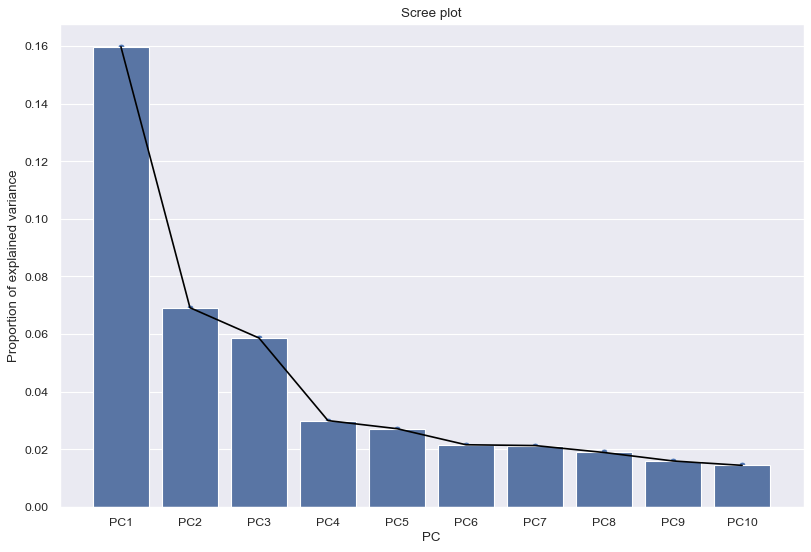

In [15]:
# Create data frame for plotting purposes
dfPCA = pd.DataFrame({'PC':['PC'+str(i) for i in range(1,11)],
        'Proportion of explained variance':pca.explained_variance_ratio_[0:10]})
plt.figure(figsize=(12, 8),dpi=80)
sns.barplot(data= dfPCA,x='PC',
           y = 'Proportion of explained variance',
           color='#4c72b0')
sns.scatterplot(data= dfPCA,x='PC',
         y = 'Proportion of explained variance',
         markers= "*")
sns.lineplot(data= dfPCA,x='PC',
         y = 'Proportion of explained variance',
         markers= "*",color='black')
plt.title('Scree plot')
# plt.savefig('q22.png', bbox_inches='tight',dpi=600)

Text(0.5, 1.0, 'Principal componets of 2 cell-lines samples')

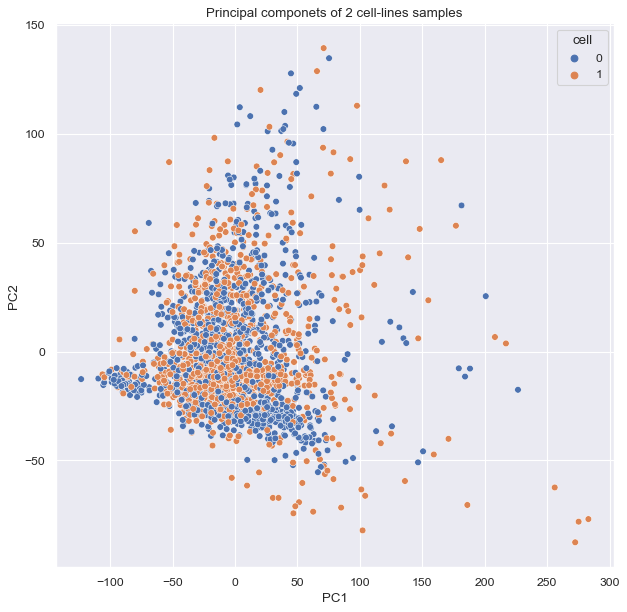

In [23]:
plt.figure(figsize=(9, 9),dpi=80)
sns.scatterplot(data=Xpca,x='PC1',y='PC2',
                hue='cell')
plt.title('Principal componets of 2 cell-lines samples')
#plt.savefig('q223.png', bbox_inches='tight',dpi=600)

In [14]:
X_tsne = TSNE(n_components=2,init= 'pca',perplexity=50,verbose=0).fit_transform(cmap.iloc[:,:-1])

C:\Users\nmeim\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\nmeim\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [16]:
X_tsne = pd.DataFrame(X_tsne)
X_tsne.columns = ['Dim'+str(i) for i in range(1,3)]
X_tsne['cell'] = cmap.cell.values
X_tsne.index = cmap.index
#display(X_tsne)

Text(0.5, 1.0, 't-SNE plot of 2 cell-lines samples')

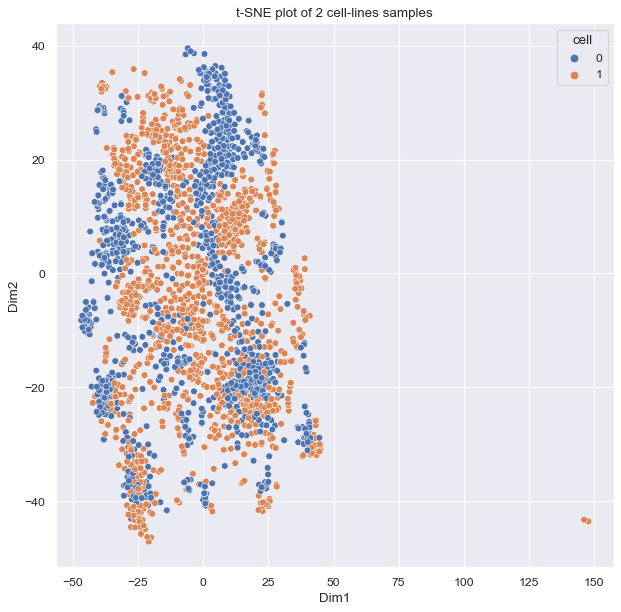

In [17]:
plt.figure(figsize=(9, 9),dpi=80)
sns.scatterplot(data=X_tsne,x='Dim1',y='Dim2',
                hue='cell')
plt.title('t-SNE plot of 2 cell-lines samples')
#plt.savefig('q223.png', bbox_inches='tight',dpi=600)

In [18]:
X_umap = umap.UMAP().fit_transform(cmap.iloc[:,:-1])

C:\Users\nmeim\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [19]:
X_umap = pd.DataFrame(X_umap)
X_umap.columns = ['uMAP-'+str(i) for i in range(1,3)]
X_umap['cell'] = cmap.cell.values
X_umap.index = cmap.index
#display(X_umap)

Text(0.5, 1.0, 'u-MAP plot of 2 cell-lines samples')

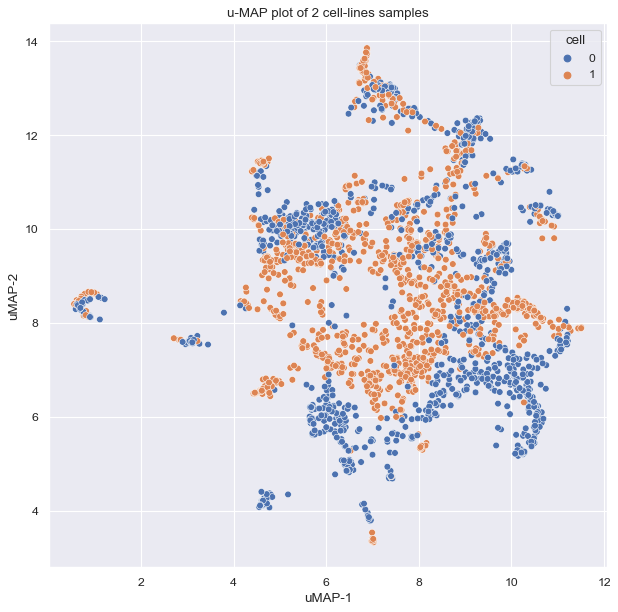

In [20]:
plt.figure(figsize=(9, 9),dpi=80)
sns.scatterplot(data=X_umap,x='uMAP-1',y='uMAP-2',
                hue='cell')
plt.title('u-MAP plot of 2 cell-lines samples')
#plt.savefig('q223.png', bbox_inches='tight',dpi=600)

# Train classifier with PCs

In [25]:
criterion = torch.nn.CrossEntropyLoss()
bs=128
k_folds=10
NUM_EPOCHS=1000
bs_1 = 178
bs_2 =  154
bs_paired =  90

Fold=0, Epoch=1/1000, L2 Loss=10.3457, Entropy Loss=0.7015, loss=11.0472, Accuracy=0.5476, F1 score=0.5128
Fold=0, Epoch=101/1000, L2 Loss=0.2777, Entropy Loss=0.5616, loss=0.8392, Accuracy=0.7143, F1 score=0.7391
Fold=0, Epoch=201/1000, L2 Loss=0.2712, Entropy Loss=0.4413, loss=0.7125, Accuracy=0.8810, F1 score=0.8837
Fold=0, Epoch=301/1000, L2 Loss=0.3282, Entropy Loss=0.5086, loss=0.8369, Accuracy=0.8095, F1 score=0.8182
Fold=0, Epoch=401/1000, L2 Loss=0.2858, Entropy Loss=0.4653, loss=0.7511, Accuracy=0.8333, F1 score=0.8372
Fold=0, Epoch=501/1000, L2 Loss=0.2857, Entropy Loss=0.4420, loss=0.7277, Accuracy=0.9048, F1 score=0.9048
Fold=0, Epoch=601/1000, L2 Loss=0.3266, Entropy Loss=0.5469, loss=0.8735, Accuracy=0.7381, F1 score=0.7317
Fold=0, Epoch=701/1000, L2 Loss=0.2790, Entropy Loss=0.3983, loss=0.6773, Accuracy=0.9048, F1 score=0.9091
Fold=0, Epoch=801/1000, L2 Loss=0.2751, Entropy Loss=0.4916, loss=0.7667, Accuracy=0.8095, F1 score=0.8182
Fold=0, Epoch=901/1000, L2 Loss=0.274

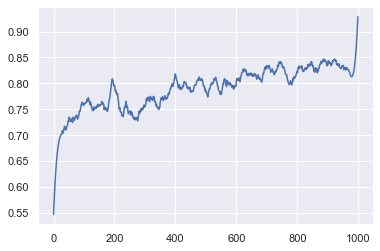

Fold=1, Epoch=1/1000, L2 Loss=10.3137, Entropy Loss=0.7291, loss=11.0428, Accuracy=0.5000, F1 score=0.5882
Fold=1, Epoch=101/1000, L2 Loss=0.2727, Entropy Loss=0.5045, loss=0.7772, Accuracy=0.8095, F1 score=0.8000
Fold=1, Epoch=201/1000, L2 Loss=0.2585, Entropy Loss=0.5131, loss=0.7716, Accuracy=0.8333, F1 score=0.8293
Fold=1, Epoch=301/1000, L2 Loss=0.2907, Entropy Loss=0.5314, loss=0.8221, Accuracy=0.7619, F1 score=0.7619
Fold=1, Epoch=401/1000, L2 Loss=0.2576, Entropy Loss=0.5211, loss=0.7787, Accuracy=0.7857, F1 score=0.7805
Fold=1, Epoch=501/1000, L2 Loss=0.3011, Entropy Loss=0.4794, loss=0.7805, Accuracy=0.8571, F1 score=0.8696
Fold=1, Epoch=601/1000, L2 Loss=0.2997, Entropy Loss=0.4945, loss=0.7942, Accuracy=0.8333, F1 score=0.8372
Fold=1, Epoch=701/1000, L2 Loss=0.2790, Entropy Loss=0.4915, loss=0.7705, Accuracy=0.8095, F1 score=0.8182
Fold=1, Epoch=801/1000, L2 Loss=0.2949, Entropy Loss=0.4638, loss=0.7587, Accuracy=0.8333, F1 score=0.8293
Fold=1, Epoch=901/1000, L2 Loss=0.287

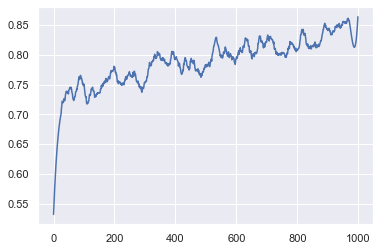

Fold=2, Epoch=1/1000, L2 Loss=10.3885, Entropy Loss=0.8007, loss=11.1892, Accuracy=0.3810, F1 score=0.3500
Fold=2, Epoch=101/1000, L2 Loss=0.2698, Entropy Loss=0.5242, loss=0.7940, Accuracy=0.7857, F1 score=0.7568
Fold=2, Epoch=201/1000, L2 Loss=0.2523, Entropy Loss=0.6003, loss=0.8526, Accuracy=0.6667, F1 score=0.7200
Fold=2, Epoch=301/1000, L2 Loss=0.2699, Entropy Loss=0.5183, loss=0.7882, Accuracy=0.7857, F1 score=0.7805


KeyboardInterrupt: 

In [26]:
valF1 = []
valAcc = []
valPrec = []
valRec = []
#for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):
for fold in range(10):    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%fold,index_col=0)
    trainInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%fold,index_col=0)
    trainInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%fold,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%fold,index_col=0)
    valInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%fold,index_col=0)
    valInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%fold,index_col=0)
    
    #xtrain,ytrain = dataset[train_idx]
    #xtest,ytest = dataset[test_idx]
    #N = ytrain.shape[0]
    N_paired = len(trainInfo_paired)
    N_1 = len(trainInfo_1)
    N_2 = len(trainInfo_2)
    N = N_1
    if N_2>N:
        N=N_2
    model = CellBinaryClassifier(in_channel=1024,hidden_layers=[512,256,128],drop_in=0.5,drop=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=300,
                                                gamma=0.8)
    trainAcc = []
    for e in range(NUM_EPOCHS):
        model.train()
        #trainloader = getSamples(N, bs)
        trainloader_1 = getSamples(N_1, bs_1)
        len_1 = len(trainloader_1)
        trainloader_2 = getSamples(N_2, bs_2)
        len_2 = len(trainloader_2)
        trainloader_paired = getSamples(N_paired, bs_paired)
        len_paired = len(trainloader_paired)
        lens = [len_1,len_2,len_paired]
        maxLen = np.max(lens)
        if maxLen>lens[0]:
            trainloader_suppl = getSamples(N_1, bs_1)
            for jj in range(maxLen-lens[0]):
                trainloader_1.insert(jj,trainloader_suppl[jj])
        if maxLen>lens[1]:
            trainloader_suppl = getSamples(N_2, bs_2)
            for jj in range(maxLen-lens[1]):
                trainloader_2.insert(jj,trainloader_suppl[jj])
        if maxLen>lens[2]:
            trainloader_suppl = getSamples(N_paired, bs_paired)
            for jj in range(maxLen-lens[2]):
                trainloader_paired.insert(jj,trainloader_suppl[jj])
        
        #for dataIndex in trainloader:
        for j in range(maxLen):
            dataIndex_1 = trainloader_1[j]
            dataIndex_2 = trainloader_2[j]
            dataIndex_paired = trainloader_paired[j]
            
            df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
            df_1 = trainInfo_1.iloc[dataIndex_1,:]
            df_2 = trainInfo_2.iloc[dataIndex_2,:]
            paired_inds = len(df_pairs)
            
            X_1 = torch.tensor(np.concatenate((Xpca.loc[df_pairs['sig_id.x'],Xpca.columns!='cell'].values,
                                                 Xpca.loc[df_1.sig_id,Xpca.columns!='cell'].values))).float().detach()
            X_2 = torch.tensor(np.concatenate((Xpca.loc[df_pairs['sig_id.y'],Xpca.columns!='cell'].values,
                                                 Xpca.loc[df_2.sig_id,Xpca.columns!='cell'].values))).float().detach()
            
            dataIn = torch.cat((X_1,X_2),0).detach().to(device)
            dataOut = torch.cat((torch.ones(X_1.shape[0]),torch.zeros(X_2.shape[0])),0).long()
            
            optimizer.zero_grad()
            #dataIn = xtrain[dataIndex].to(device)
            #dataOut = ytrain[dataIndex].to(device)
            out = model(dataIn)
            L2Loss = model.L2Regularization(1e-2)
            loss = criterion(out, dataOut.to(device)) + L2Loss
            
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(out, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(dataOut.cpu(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            acc = (tp+tn)/predicted.size
            f1 = 2*tp/(2*tp+fp+fn)
        if e%100==0:
            outString = 'Fold={:.0f}'.format(fold)
            outString += ', Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
            outString += ', L2 Loss={:.4f}'.format(L2Loss.item())
            outString += ', Entropy Loss={:.4f}'.format(loss.item()-L2Loss.item())
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', Accuracy={:.4f}'.format(acc)
            outString += ', F1 score={:.4f}'.format(f1)
            print(outString)
            #clear_output(wait=True)
        trainAcc.append(f1)
        scheduler.step()
    outString = 'Fold={:.0f}'.format(fold)
    outString += ', Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
    outString += ', L2 Loss={:.4f}'.format(L2Loss.item())
    outString += ', Entropy Loss={:.4f}'.format(loss.item()-L2Loss.item())
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', Accuracy={:.4f}'.format(acc)
    outString += ', F1 score={:.4f}'.format(f1)
    print(outString)
    
    model.eval()
    paired_val_inds = len(valInfo_paired)
    x_1 = torch.tensor(np.concatenate((Xpca.loc[valInfo_paired['sig_id.x'],Xpca.columns!='cell'].values,
                                          Xpca.loc[valInfo_1.sig_id,Xpca.columns!='cell'].values))).float().detach()
    x_2 = torch.tensor(np.concatenate((Xpca.loc[valInfo_paired['sig_id.y'],Xpca.columns!='cell'].values,
                                          Xpca.loc[valInfo_2.sig_id,Xpca.columns!='cell'].values))).float().detach()
    xtest = torch.cat((x_1,x_2),0).detach()
    ytest = torch.cat((torch.ones(x_1.shape[0]),torch.zeros(x_2.shape[0])),0).long().numpy()
    
    test_out = model(xtest.to(device))
    _, predicted = torch.max(test_out, 1)
    predicted = predicted.cpu().numpy()
    cf_matrix = confusion_matrix(ytest,predicted)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc = (tp+tn)/predicted.size
    rec = tp/(tp+fn)
    prec = tp/(tp+fp)
    f1 = 2*tp/(2*tp+fp+fn)
    outString = 'Test-set performance: Fold={:.0f}'.format(fold)
    outString += ', Accuracy={:.4f}'.format(acc)
    outString += ', F1 score={:.4f}'.format(f1)
    outString += ', Precision={:.4f}'.format(prec)
    outString += ', Recall={:.4f}'.format(rec)
    print(outString)
    Y = savgol_filter(trainAcc, 51, 3)
    plt.figure()
    plt.plot(range(NUM_EPOCHS),Y)
    #plt.ylim(0,1)
    #plt.yscale('log')
    plt.show()
    valF1.append(f1)
    valAcc.append(acc)
    valPrec.append(prec)
    valRec.append(rec)

In [ ]:
print(np.mean(valAcc))
print(np.mean(valF1))
print(np.mean(valPrec))
print(np.mean(valRec))

In [ ]:
print(np.std(valAcc)/np.sqrt(10))
print(np.std(valF1)/np.sqrt(10))
print(np.std(valPrec)/np.sqrt(10))
print(np.std(valRec)/np.sqrt(10))

In [ ]:
print(valAcc)
print(valF1)

In [22]:
df = pd.DataFrame({'Acc':valAcc,'F1':valF1})
df.to_csv('../results/allgenes_PCA_classifier_trainedEmbs_a375_ht29.csv')

# Use TransCompR transformed data

In [9]:
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_HT29_A375.csv',index_col=0)
cmap = cmap.loc[pd.concat((sampleInfo_1.sig_id,sampleInfo_paired['sig_id.x'],
                            sampleInfo_2.sig_id,sampleInfo_paired['sig_id.y'])).drop_duplicates().reset_index(drop=True),
                 :].drop_duplicates()
cmap

,16,23,25,30,39,47,102,128,142,154,...,729230,729515,100129250,100131755,100132406,100287932,100289678,100507436,9142,26148
DOSBIO001_A375_24H:BRD-K72343629:10.1316,1.545521,1.061800,1.165320,-1.052685,-3.449826,0.503872,1.850187,-0.426328,0.004190,1.948446,...,-0.091040,0.040860,0.378187,1.264697,-0.450258,-1.153419,0.232950,-1.387834,0.104525,-0.515325
DOSBIO002_A375_24H:BRD-K22052171:9.97874,0.573862,-1.478506,1.284757,1.114560,-1.628030,0.559048,0.799478,0.675117,0.988028,-1.850497,...,-0.736037,-0.446497,0.646688,-0.098381,-0.202127,-1.297316,0.277845,-0.046932,-0.117402,-0.210667
DOSBIO002_A375_24H:BRD-K25379780:10.5212,0.468655,-0.864797,-0.182940,-0.529013,1.603291,1.815907,-0.188831,0.805886,1.100750,-1.278348,...,-0.739619,-0.218896,0.403286,-0.028610,0.200646,0.160801,0.141702,-0.175934,-0.910911,-1.190587
DOSBIO002_A375_24H:BRD-K87125912:9.98177,0.624088,-0.239281,-0.235216,0.951562,7.336524,4.183496,0.068398,-1.822858,-2.063225,-1.541112,...,1.396117,-0.174704,0.519222,0.669299,-0.323203,-1.514915,-0.961175,1.848807,-0.208447,0.279424
DOSBIO001_A375_24H:BRD-K70900504:10.0464,1.510834,2.235203,0.867541,-0.436479,-2.886851,0.172087,1.488347,-0.646825,-0.688189,1.123355,...,0.506248,-1.307817,0.301336,0.561701,-1.005974,0.426153,-0.177931,-0.194986,0.548976,1.016693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPC012_HT29_6H:BRD-K74761218-001-03-5:10,-1.650206,0.019022,-1.028554,0.209129,-1.245795,0.833030,0.778063,-0.895520,-1.206261,1.346442,...,-0.621593,0.945812,0.419918,-0.668789,0.460151,0.440341,-1.884926,1.830030,0.334797,-1.431227
CPC006_HT29_24H:BRD-A62182663-001-01-4:10,0.143746,-0.044304,0.296172,0.184163,-0.616859,-0.531261,3.590796,-1.901928,0.958495,0.427105,...,-0.905865,-1.424886,1.130776,-0.421499,0.438033,0.331161,-0.104879,0.451170,0.006299,0.782695
CPC013_HT29_6H:A15,-0.787285,-0.197107,-1.044924,1.059091,0.435514,-0.553575,-1.036044,-0.109397,-1.271592,1.218367,...,0.375502,0.215030,-0.617606,0.371418,-0.542508,0.826989,-1.606035,-0.034839,-0.181367,0.292102
REP.A022_HT29_24H:J01,0.253279,3.065412,0.041579,0.283965,-0.422361,0.300706,0.250005,-1.572236,0.559977,4.469641,...,1.470468,-0.962584,-0.246275,0.122734,0.893849,0.661904,-0.789807,-0.979607,0.519886,0.074205


In [16]:
# Fit PCA
pca1 = PCA(n_components=1024)
pca1.fit(pd.concat((cmap.loc[sampleInfo_paired['sig_id.x'],:],
                    cmap.loc[sampleInfo_1.sig_id,:])))
# Get PCA matrix
Xpca2_translated = pca1.transform(pd.concat((cmap.loc[sampleInfo_paired['sig_id.y'],:],
                                             cmap.loc[sampleInfo_2.sig_id,:])))
Xpca2_translated = pd.DataFrame(Xpca2_translated)
Xpca2_translated.columns = ['PC'+str(i) for i in range(1,1025)]
Xpca2_translated.index = list(sampleInfo_paired['sig_id.y']) + list(sampleInfo_2.sig_id)
display(Xpca2_translated)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1015,PC1016,PC1017,PC1018,PC1019,PC1020,PC1021,PC1022,PC1023,PC1024
PBIOA019_HT29_24H:L07,-2.847624,9.480224,6.711027,4.596431,-8.899391,-1.939262,14.932564,10.189834,-7.677620,1.047995,...,0.967986,-0.568191,-2.239269,-0.469798,-0.679350,0.023169,1.148088,-0.704228,0.056607,-3.525562
CPC018_HT29_6H:BRD-A62890442-001-01-0:10,-81.380695,-10.887494,-8.170485,6.523108,2.721475,8.591174,0.254033,5.140728,-4.542197,3.660513,...,-0.518882,0.438775,-0.276431,1.789239,-0.697264,-0.359714,-0.566313,-0.469830,-0.055276,0.333915
CPC016_HT29_6H:BRD-K89930444-001-01-9:10,-26.061826,41.175679,3.226483,0.694527,17.548773,-4.525284,22.285222,-6.540033,-6.408931,5.352472,...,-0.677498,0.031629,-0.721698,0.366163,0.007588,1.544363,-0.622467,1.299768,-0.409066,-1.158159
CPC017_HT29_6H:BRD-K59469039-001-03-1:10,1.038972,-4.379182,-7.167990,3.601089,5.347221,-15.382850,-8.003149,-9.541058,-2.658197,9.627490,...,1.617241,-1.461946,-0.970907,0.778238,-0.365604,0.660216,-0.575485,1.188797,-0.687138,0.388902
REP.A007_HT29_24H:L01,-21.836127,1.690884,49.758134,13.710506,-0.907365,-11.578801,13.575507,-14.899783,-2.512942,-11.384886,...,0.267688,-2.674535,0.114222,0.607676,0.447127,0.111573,1.560097,0.387574,-0.200943,0.057171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL005_HT29_24H:BRD-K83216232:10,-28.102907,-15.467013,-9.645662,-8.364298,16.807045,-4.666161,-3.537690,-0.280468,0.821168,1.500117,...,-0.286443,-0.688359,-0.120236,0.553813,0.504581,0.006696,-1.111282,1.974495,0.333068,0.741931
DOSVAL001_HT29_24H:BRD-K34624563:2.5,18.137470,-17.020537,-17.686678,-11.555139,-8.042736,-9.606444,-3.243719,-2.582846,5.955609,-5.603744,...,-0.039786,-0.589729,-0.911569,-0.558755,0.489255,0.728507,1.035251,-0.395100,-0.143780,-0.381864
DOSVAL001_HT29_24H:BRD-K56923419:2.49753,23.636711,-17.317463,-35.870529,-15.879353,-15.695775,-7.374986,-8.644018,2.720472,4.717063,-1.560337,...,0.841448,0.443779,-0.803729,-0.945199,-0.663786,1.434466,0.391748,0.226520,-0.713427,-1.362852
DOSVAL001_HT29_24H:BRD-K11432829:10.0841,-7.113671,12.597328,13.152726,-5.024318,1.732346,-2.241006,1.475337,-13.276011,-9.749095,-2.372894,...,0.270145,-2.528721,0.028863,0.679391,0.138658,-0.083441,0.812376,-0.290588,-0.289444,0.307633


In [15]:
# Fit PCA
pca2 = PCA(n_components=1024)
pca2.fit(pd.concat((cmap.loc[sampleInfo_paired['sig_id.y'],:],
                    cmap.loc[sampleInfo_2.sig_id,:])))
# Get PCA matrix
Xpca1_translated = pca2.transform(pd.concat((cmap.loc[sampleInfo_paired['sig_id.x'],:],
                                             cmap.loc[sampleInfo_1.sig_id,:])))
Xpca1_translated = pd.DataFrame(Xpca1_translated)
Xpca1_translated.columns = ['PC'+str(i) for i in range(1,1025)]
Xpca1_translated.index = list(sampleInfo_paired['sig_id.x']) + list(sampleInfo_1.sig_id)
display(Xpca1_translated)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1015,PC1016,PC1017,PC1018,PC1019,PC1020,PC1021,PC1022,PC1023,PC1024
PBIOA019_A375_24H:L07,105.553191,12.800871,-59.126194,-43.054254,-20.306524,-9.381383,1.287730,0.798504,15.601862,15.472149,...,1.904154,-1.243071,1.426335,-0.374915,-0.812511,-0.933132,-2.511772,3.664240,0.501634,1.792389
CPC018_A375_6H:BRD-A62890442-001-01-0:10,-79.930061,-14.779308,5.038751,4.874517,8.200237,3.386196,6.329651,-0.406635,-1.546641,6.298018,...,-0.188655,0.290795,-1.495146,-0.271388,-0.418387,0.406295,0.213588,-0.353658,-0.230375,-0.437498
CPC016_A375_6H:BRD-K89930444-001-01-9:10,-10.057760,8.049705,-12.101716,-3.776215,-11.905007,14.541748,13.486043,-11.932166,-2.265685,-6.444124,...,0.008127,0.131557,0.968908,0.524773,0.295950,-0.439553,1.470142,0.506626,-0.798730,0.051711
CPC017_A375_6H:BRD-K59469039-001-03-1:10,26.437560,-1.737549,-11.115215,-8.828896,-15.419957,26.388093,15.639246,-15.668178,-11.360300,-4.046452,...,1.186411,0.461868,-0.853338,0.318696,-0.049870,-0.492190,-0.131760,0.233478,-0.451474,0.845391
REP.A007_A375_24H:L01,-24.694774,-0.644778,16.671338,-0.820715,-2.653515,-0.415741,-12.083323,4.362392,-3.781447,11.724304,...,-0.747773,-0.895528,1.272010,-0.062581,-1.044197,-0.796342,1.184573,-0.197953,-0.139115,0.948870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL002_A375_24H:BRD-K98645985:20,16.591580,-25.200226,-1.843510,0.134293,-9.488865,-16.128247,13.954050,-2.132653,-4.792519,9.685838,...,-1.236422,0.092558,-1.137926,-2.028155,-0.459676,-0.497990,-0.670834,-0.000537,-0.721154,1.648585
DOSVAL004_A375_24H:BRD-K21680192:5,162.637460,-54.941921,-14.016970,19.382793,23.711405,48.709758,1.138386,-12.686514,12.131111,-7.096445,...,0.074883,0.231858,-1.907710,-0.916185,-2.070901,1.372957,0.147597,1.466100,-2.264061,-0.195489
DOSVAL001_A375_24H:BRD-K09050080:10.1383,16.329566,21.420292,-18.467897,-19.300504,-19.080790,-6.946625,-18.008983,4.983137,-6.374892,3.800662,...,-0.086645,0.151925,-0.329795,0.562141,-0.929677,1.043936,0.160373,0.682136,0.232735,-0.167352
DOSVAL005_A375_24H:BRD-K74461819:20,36.839939,47.456658,43.386920,-12.014481,-2.101382,-0.425326,-4.469005,11.927134,10.507986,24.557149,...,-2.045684,-0.803530,-2.128700,-0.242237,0.399311,-1.534826,0.058695,0.439421,1.252521,-0.673843


In [12]:
criterion = torch.nn.CrossEntropyLoss()
bs=128
k_folds=10
NUM_EPOCHS=1000
bs_1 = 178
bs_2 =  154
bs_paired =  90

Fold=0, Epoch=1/1000, L2 Loss=10.4220, Entropy Loss=0.5913, loss=11.0132, Accuracy=0.7500, F1 score=0.7442
Fold=0, Epoch=101/1000, L2 Loss=0.1700, Entropy Loss=0.3300, loss=0.5000, Accuracy=1.0000, F1 score=1.0000
Fold=0, Epoch=201/1000, L2 Loss=0.1344, Entropy Loss=0.3133, loss=0.4477, Accuracy=1.0000, F1 score=1.0000
Fold=0, Epoch=301/1000, L2 Loss=0.1434, Entropy Loss=0.3608, loss=0.5042, Accuracy=0.9524, F1 score=0.9524
Fold=0, Epoch=401/1000, L2 Loss=0.2084, Entropy Loss=0.3316, loss=0.5400, Accuracy=0.9767, F1 score=0.9767
Fold=0, Epoch=501/1000, L2 Loss=0.0524, Entropy Loss=0.3394, loss=0.3918, Accuracy=0.9762, F1 score=0.9756
Fold=0, Epoch=601/1000, L2 Loss=0.0835, Entropy Loss=0.3161, loss=0.3996, Accuracy=1.0000, F1 score=1.0000
Fold=0, Epoch=701/1000, L2 Loss=0.1275, Entropy Loss=0.3608, loss=0.4884, Accuracy=0.9524, F1 score=0.9524
Fold=0, Epoch=801/1000, L2 Loss=0.0875, Entropy Loss=0.3374, loss=0.4249, Accuracy=0.9762, F1 score=0.9756
Fold=0, Epoch=901/1000, L2 Loss=0.133

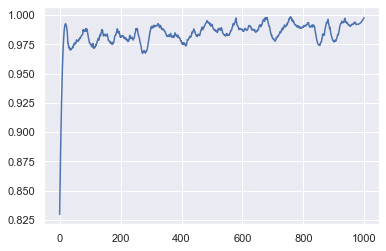

Fold=1, Epoch=1/1000, L2 Loss=10.5013, Entropy Loss=0.5524, loss=11.0536, Accuracy=0.7381, F1 score=0.7317
Fold=1, Epoch=101/1000, L2 Loss=0.1536, Entropy Loss=0.3364, loss=0.4900, Accuracy=0.9762, F1 score=0.9767
Fold=1, Epoch=201/1000, L2 Loss=0.1245, Entropy Loss=0.3483, loss=0.4727, Accuracy=0.9545, F1 score=0.9565
Fold=1, Epoch=301/1000, L2 Loss=0.2372, Entropy Loss=0.3133, loss=0.5506, Accuracy=1.0000, F1 score=1.0000
Fold=1, Epoch=401/1000, L2 Loss=0.1409, Entropy Loss=0.3330, loss=0.4738, Accuracy=0.9762, F1 score=0.9767
Fold=1, Epoch=501/1000, L2 Loss=0.1600, Entropy Loss=0.3572, loss=0.5172, Accuracy=0.9545, F1 score=0.9524
Fold=1, Epoch=601/1000, L2 Loss=0.1524, Entropy Loss=0.3337, loss=0.4861, Accuracy=0.9773, F1 score=0.9767
Fold=1, Epoch=701/1000, L2 Loss=0.1078, Entropy Loss=0.3294, loss=0.4372, Accuracy=0.9792, F1 score=0.9787
Fold=1, Epoch=801/1000, L2 Loss=0.1213, Entropy Loss=0.3835, loss=0.5048, Accuracy=0.9286, F1 score=0.9268
Fold=1, Epoch=901/1000, L2 Loss=0.077

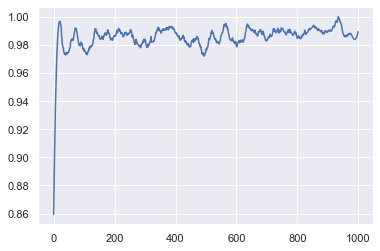

Fold=2, Epoch=1/1000, L2 Loss=10.4418, Entropy Loss=0.6093, loss=11.0511, Accuracy=0.7143, F1 score=0.7273
Fold=2, Epoch=101/1000, L2 Loss=0.1370, Entropy Loss=0.3137, loss=0.4507, Accuracy=1.0000, F1 score=1.0000
Fold=2, Epoch=201/1000, L2 Loss=0.2077, Entropy Loss=0.3332, loss=0.5409, Accuracy=0.9773, F1 score=0.9767
Fold=2, Epoch=301/1000, L2 Loss=0.1122, Entropy Loss=0.3438, loss=0.4560, Accuracy=0.9565, F1 score=0.9565
Fold=2, Epoch=401/1000, L2 Loss=0.1716, Entropy Loss=0.3161, loss=0.4877, Accuracy=1.0000, F1 score=1.0000
Fold=2, Epoch=501/1000, L2 Loss=0.1326, Entropy Loss=0.3133, loss=0.4458, Accuracy=1.0000, F1 score=1.0000
Fold=2, Epoch=601/1000, L2 Loss=0.1352, Entropy Loss=0.3141, loss=0.4493, Accuracy=1.0000, F1 score=1.0000
Fold=2, Epoch=701/1000, L2 Loss=0.0989, Entropy Loss=0.3360, loss=0.4349, Accuracy=0.9773, F1 score=0.9778
Fold=2, Epoch=801/1000, L2 Loss=0.0489, Entropy Loss=0.3133, loss=0.3622, Accuracy=1.0000, F1 score=1.0000
Fold=2, Epoch=901/1000, L2 Loss=0.058

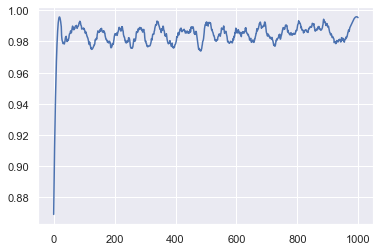

Fold=3, Epoch=1/1000, L2 Loss=10.4702, Entropy Loss=0.5239, loss=10.9941, Accuracy=0.8636, F1 score=0.8636
Fold=3, Epoch=101/1000, L2 Loss=0.1647, Entropy Loss=0.3400, loss=0.5048, Accuracy=0.9545, F1 score=0.9565
Fold=3, Epoch=201/1000, L2 Loss=0.1200, Entropy Loss=0.3138, loss=0.4338, Accuracy=1.0000, F1 score=1.0000
Fold=3, Epoch=301/1000, L2 Loss=0.1326, Entropy Loss=0.3334, loss=0.4661, Accuracy=0.9762, F1 score=0.9767
Fold=3, Epoch=401/1000, L2 Loss=0.1704, Entropy Loss=0.3133, loss=0.4837, Accuracy=1.0000, F1 score=1.0000
Fold=3, Epoch=501/1000, L2 Loss=0.1252, Entropy Loss=0.3134, loss=0.4386, Accuracy=1.0000, F1 score=1.0000
Fold=3, Epoch=601/1000, L2 Loss=0.2252, Entropy Loss=0.3136, loss=0.5388, Accuracy=1.0000, F1 score=1.0000
Fold=3, Epoch=701/1000, L2 Loss=0.0748, Entropy Loss=0.3332, loss=0.4079, Accuracy=0.9783, F1 score=0.9778
Fold=3, Epoch=801/1000, L2 Loss=0.1265, Entropy Loss=0.3259, loss=0.4524, Accuracy=0.9762, F1 score=0.9756
Fold=3, Epoch=901/1000, L2 Loss=0.090

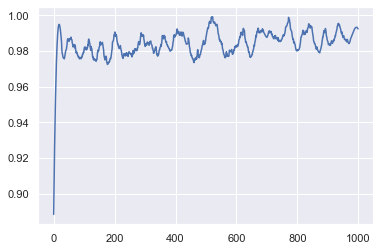

Fold=4, Epoch=1/1000, L2 Loss=10.4894, Entropy Loss=0.5545, loss=11.0440, Accuracy=0.8095, F1 score=0.8095
Fold=4, Epoch=101/1000, L2 Loss=0.2021, Entropy Loss=0.3133, loss=0.5154, Accuracy=1.0000, F1 score=1.0000
Fold=4, Epoch=201/1000, L2 Loss=0.2318, Entropy Loss=0.3407, loss=0.5725, Accuracy=0.9545, F1 score=0.9524
Fold=4, Epoch=301/1000, L2 Loss=0.1613, Entropy Loss=0.3135, loss=0.4747, Accuracy=1.0000, F1 score=1.0000
Fold=4, Epoch=401/1000, L2 Loss=0.1308, Entropy Loss=0.3133, loss=0.4441, Accuracy=1.0000, F1 score=1.0000
Fold=4, Epoch=501/1000, L2 Loss=0.1035, Entropy Loss=0.3242, loss=0.4277, Accuracy=0.9792, F1 score=0.9787
Fold=4, Epoch=601/1000, L2 Loss=0.1477, Entropy Loss=0.3428, loss=0.4905, Accuracy=0.9762, F1 score=0.9756
Fold=4, Epoch=701/1000, L2 Loss=0.1188, Entropy Loss=0.3215, loss=0.4403, Accuracy=1.0000, F1 score=1.0000
Fold=4, Epoch=801/1000, L2 Loss=0.1284, Entropy Loss=0.3217, loss=0.4500, Accuracy=1.0000, F1 score=1.0000
Fold=4, Epoch=901/1000, L2 Loss=0.067

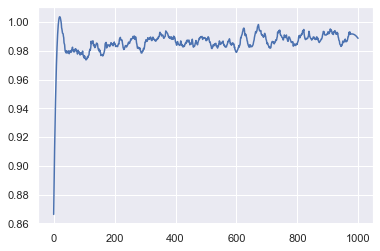

Fold=5, Epoch=1/1000, L2 Loss=10.4160, Entropy Loss=0.5492, loss=10.9652, Accuracy=0.8000, F1 score=0.7692
Fold=5, Epoch=101/1000, L2 Loss=0.1376, Entropy Loss=0.3605, loss=0.4981, Accuracy=0.9524, F1 score=0.9524
Fold=5, Epoch=201/1000, L2 Loss=0.0995, Entropy Loss=0.3238, loss=0.4232, Accuracy=0.9783, F1 score=0.9778
Fold=5, Epoch=301/1000, L2 Loss=0.1517, Entropy Loss=0.3360, loss=0.4877, Accuracy=0.9773, F1 score=0.9767
Fold=5, Epoch=401/1000, L2 Loss=0.1550, Entropy Loss=0.3133, loss=0.4683, Accuracy=1.0000, F1 score=1.0000
Fold=5, Epoch=501/1000, L2 Loss=0.2066, Entropy Loss=0.3133, loss=0.5199, Accuracy=1.0000, F1 score=1.0000
Fold=5, Epoch=601/1000, L2 Loss=0.0928, Entropy Loss=0.3137, loss=0.4065, Accuracy=1.0000, F1 score=1.0000
Fold=5, Epoch=701/1000, L2 Loss=0.0931, Entropy Loss=0.3133, loss=0.4064, Accuracy=1.0000, F1 score=1.0000
Fold=5, Epoch=801/1000, L2 Loss=0.1081, Entropy Loss=0.3715, loss=0.4796, Accuracy=0.9388, F1 score=0.9362
Fold=5, Epoch=901/1000, L2 Loss=0.089

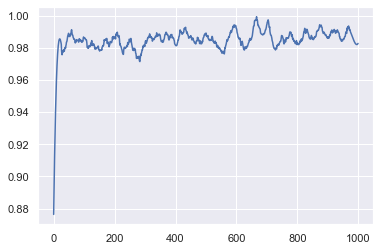

Fold=6, Epoch=1/1000, L2 Loss=10.3675, Entropy Loss=0.6168, loss=10.9842, Accuracy=0.6383, F1 score=0.5641
Fold=6, Epoch=101/1000, L2 Loss=0.1375, Entropy Loss=0.3408, loss=0.4782, Accuracy=0.9762, F1 score=0.9756
Fold=6, Epoch=201/1000, L2 Loss=0.1670, Entropy Loss=0.3347, loss=0.5016, Accuracy=0.9783, F1 score=0.9778
Fold=6, Epoch=301/1000, L2 Loss=0.1503, Entropy Loss=0.3479, loss=0.4983, Accuracy=0.9773, F1 score=0.9767
Fold=6, Epoch=401/1000, L2 Loss=0.1366, Entropy Loss=0.3371, loss=0.4737, Accuracy=0.9762, F1 score=0.9756
Fold=6, Epoch=501/1000, L2 Loss=0.1227, Entropy Loss=0.3133, loss=0.4360, Accuracy=1.0000, F1 score=1.0000
Fold=6, Epoch=601/1000, L2 Loss=0.2073, Entropy Loss=0.3210, loss=0.5283, Accuracy=1.0000, F1 score=1.0000
Fold=6, Epoch=701/1000, L2 Loss=0.1395, Entropy Loss=0.3551, loss=0.4946, Accuracy=0.9556, F1 score=0.9524
Fold=6, Epoch=801/1000, L2 Loss=0.0743, Entropy Loss=0.3375, loss=0.4118, Accuracy=0.9762, F1 score=0.9767
Fold=6, Epoch=901/1000, L2 Loss=0.086

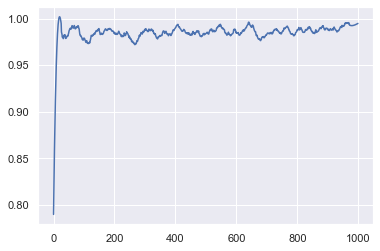

Fold=7, Epoch=1/1000, L2 Loss=10.4747, Entropy Loss=0.5551, loss=11.0298, Accuracy=0.7857, F1 score=0.7692
Fold=7, Epoch=101/1000, L2 Loss=0.1792, Entropy Loss=0.3246, loss=0.5038, Accuracy=0.9792, F1 score=0.9796
Fold=7, Epoch=201/1000, L2 Loss=0.2156, Entropy Loss=0.3239, loss=0.5395, Accuracy=1.0000, F1 score=1.0000
Fold=7, Epoch=301/1000, L2 Loss=0.1812, Entropy Loss=0.3170, loss=0.4982, Accuracy=1.0000, F1 score=1.0000
Fold=7, Epoch=401/1000, L2 Loss=0.1270, Entropy Loss=0.3231, loss=0.4502, Accuracy=0.9773, F1 score=0.9767
Fold=7, Epoch=501/1000, L2 Loss=0.2429, Entropy Loss=0.3134, loss=0.5563, Accuracy=1.0000, F1 score=1.0000
Fold=7, Epoch=601/1000, L2 Loss=0.0666, Entropy Loss=0.3133, loss=0.3799, Accuracy=1.0000, F1 score=1.0000
Fold=7, Epoch=701/1000, L2 Loss=0.0839, Entropy Loss=0.3374, loss=0.4213, Accuracy=0.9762, F1 score=0.9756
Fold=7, Epoch=801/1000, L2 Loss=0.0604, Entropy Loss=0.3178, loss=0.3782, Accuracy=1.0000, F1 score=1.0000
Fold=7, Epoch=901/1000, L2 Loss=0.101

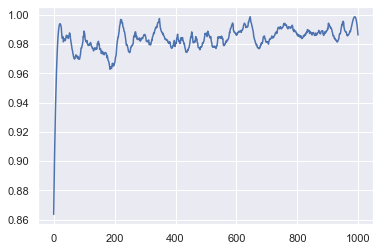

Fold=8, Epoch=1/1000, L2 Loss=10.4164, Entropy Loss=0.5899, loss=11.0063, Accuracy=0.7143, F1 score=0.6667
Fold=8, Epoch=101/1000, L2 Loss=0.1691, Entropy Loss=0.3370, loss=0.5061, Accuracy=0.9762, F1 score=0.9756
Fold=8, Epoch=201/1000, L2 Loss=0.1243, Entropy Loss=0.3362, loss=0.4606, Accuracy=0.9767, F1 score=0.9767
Fold=8, Epoch=301/1000, L2 Loss=0.1559, Entropy Loss=0.3693, loss=0.5251, Accuracy=0.9318, F1 score=0.9268
Fold=8, Epoch=401/1000, L2 Loss=0.1401, Entropy Loss=0.3151, loss=0.4552, Accuracy=1.0000, F1 score=1.0000
Fold=8, Epoch=501/1000, L2 Loss=0.1648, Entropy Loss=0.3441, loss=0.5090, Accuracy=0.9762, F1 score=0.9767
Fold=8, Epoch=601/1000, L2 Loss=0.0915, Entropy Loss=0.3159, loss=0.4074, Accuracy=1.0000, F1 score=1.0000
Fold=8, Epoch=701/1000, L2 Loss=0.0792, Entropy Loss=0.3638, loss=0.4430, Accuracy=0.9348, F1 score=0.9333
Fold=8, Epoch=801/1000, L2 Loss=0.1047, Entropy Loss=0.3150, loss=0.4197, Accuracy=1.0000, F1 score=1.0000
Fold=8, Epoch=901/1000, L2 Loss=0.061

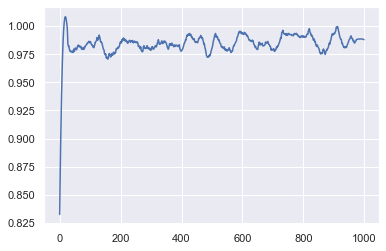

Fold=9, Epoch=1/1000, L2 Loss=10.4400, Entropy Loss=0.5140, loss=10.9540, Accuracy=0.9091, F1 score=0.9000
Fold=9, Epoch=101/1000, L2 Loss=0.1661, Entropy Loss=0.3146, loss=0.4808, Accuracy=1.0000, F1 score=1.0000
Fold=9, Epoch=201/1000, L2 Loss=0.1906, Entropy Loss=0.3463, loss=0.5369, Accuracy=0.9545, F1 score=0.9565
Fold=9, Epoch=301/1000, L2 Loss=0.1139, Entropy Loss=0.3158, loss=0.4297, Accuracy=1.0000, F1 score=1.0000
Fold=9, Epoch=401/1000, L2 Loss=0.1688, Entropy Loss=0.3160, loss=0.4848, Accuracy=1.0000, F1 score=1.0000
Fold=9, Epoch=501/1000, L2 Loss=0.1497, Entropy Loss=0.3455, loss=0.4952, Accuracy=0.9524, F1 score=0.9524
Fold=9, Epoch=601/1000, L2 Loss=0.0662, Entropy Loss=0.3133, loss=0.3795, Accuracy=1.0000, F1 score=1.0000
Fold=9, Epoch=701/1000, L2 Loss=0.0900, Entropy Loss=0.3371, loss=0.4271, Accuracy=0.9762, F1 score=0.9767
Fold=9, Epoch=801/1000, L2 Loss=0.0662, Entropy Loss=0.3273, loss=0.3935, Accuracy=0.9762, F1 score=0.9767
Fold=9, Epoch=901/1000, L2 Loss=0.110

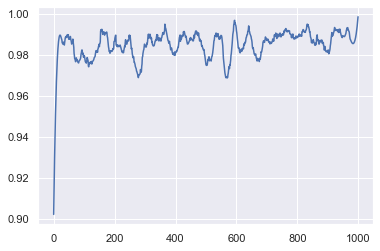

In [18]:
valF1 = []
valAcc = []
valPrec = []
valRec = []
#for fold,(train_idx,test_idx) in enumerate(kfold.split(dataset)):
for fold in range(10):    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%fold,index_col=0)
    trainInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%fold,index_col=0)
    trainInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%fold,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%fold,index_col=0)
    valInfo_1 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%fold,index_col=0)
    valInfo_2 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%fold,index_col=0)
    
    #xtrain,ytrain = dataset[train_idx]
    #xtest,ytest = dataset[test_idx]
    #N = ytrain.shape[0]
    N_paired = len(trainInfo_paired)
    N_1 = len(trainInfo_1)
    N_2 = len(trainInfo_2)
    N = N_1
    if N_2>N:
        N=N_2
    model = CellBinaryClassifier(in_channel=1024,hidden_layers=[512,256,128],drop_in=0.5,drop=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=300,
                                                gamma=0.8)
    trainAcc = []
    for e in range(NUM_EPOCHS):
        model.train()
        #trainloader = getSamples(N, bs)
        trainloader_1 = getSamples(N_1, bs_1)
        len_1 = len(trainloader_1)
        trainloader_2 = getSamples(N_2, bs_2)
        len_2 = len(trainloader_2)
        trainloader_paired = getSamples(N_paired, bs_paired)
        len_paired = len(trainloader_paired)
        lens = [len_1,len_2,len_paired]
        maxLen = np.max(lens)
        if maxLen>lens[0]:
            trainloader_suppl = getSamples(N_1, bs_1)
            for jj in range(maxLen-lens[0]):
                trainloader_1.insert(jj,trainloader_suppl[jj])
        if maxLen>lens[1]:
            trainloader_suppl = getSamples(N_2, bs_2)
            for jj in range(maxLen-lens[1]):
                trainloader_2.insert(jj,trainloader_suppl[jj])
        if maxLen>lens[2]:
            trainloader_suppl = getSamples(N_paired, bs_paired)
            for jj in range(maxLen-lens[2]):
                trainloader_paired.insert(jj,trainloader_suppl[jj])
        
        #for dataIndex in trainloader:
        for j in range(maxLen):
            dataIndex_1 = trainloader_1[j]
            dataIndex_2 = trainloader_2[j]
            dataIndex_paired = trainloader_paired[j]
            
            df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
            df_1 = trainInfo_1.iloc[dataIndex_1,:]
            df_2 = trainInfo_2.iloc[dataIndex_2,:]
            paired_inds = len(df_pairs)
            
            X_2 = torch.tensor(np.concatenate((Xpca1_translated.loc[df_pairs['sig_id.x'],Xpca1_translated.columns!='cell'].values,
                                                 Xpca1_translated.loc[df_1.sig_id,Xpca1_translated.columns!='cell'].values))).float().detach()
            X_1 = torch.tensor(np.concatenate((Xpca2_translated.loc[df_pairs['sig_id.y'],Xpca2_translated.columns!='cell'].values,
                                                 Xpca2_translated.loc[df_2.sig_id,Xpca2_translated.columns!='cell'].values))).float().detach()
            
            dataIn = torch.cat((X_1,X_2),0).detach().to(device)
            dataOut = torch.cat((torch.ones(X_1.shape[0]),torch.zeros(X_2.shape[0])),0).long()
            
            optimizer.zero_grad()
            #dataIn = xtrain[dataIndex].to(device)
            #dataOut = ytrain[dataIndex].to(device)
            out = model(dataIn)
            L2Loss = model.L2Regularization(1e-2)
            loss = criterion(out, dataOut.to(device)) + L2Loss
            
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(out, 1)
            predicted = predicted.cpu().numpy()
            cf_matrix = confusion_matrix(dataOut.cpu(),predicted)
            tn, fp, fn, tp = cf_matrix.ravel()
            acc = (tp+tn)/predicted.size
            f1 = 2*tp/(2*tp+fp+fn)
        if e%100==0:
            outString = 'Fold={:.0f}'.format(fold)
            outString += ', Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
            outString += ', L2 Loss={:.4f}'.format(L2Loss.item())
            outString += ', Entropy Loss={:.4f}'.format(loss.item()-L2Loss.item())
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', Accuracy={:.4f}'.format(acc)
            outString += ', F1 score={:.4f}'.format(f1)
            print(outString)
            #clear_output(wait=True)
        trainAcc.append(f1)
        scheduler.step()
    outString = 'Fold={:.0f}'.format(fold)
    outString += ', Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
    outString += ', L2 Loss={:.4f}'.format(L2Loss.item())
    outString += ', Entropy Loss={:.4f}'.format(loss.item()-L2Loss.item())
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', Accuracy={:.4f}'.format(acc)
    outString += ', F1 score={:.4f}'.format(f1)
    print(outString)
    
    model.eval()
    paired_val_inds = len(valInfo_paired)
    x_2 = torch.tensor(np.concatenate((Xpca1_translated.loc[valInfo_paired['sig_id.x'],Xpca1_translated.columns!='cell'].values,
                                          Xpca1_translated.loc[valInfo_1.sig_id,Xpca1_translated.columns!='cell'].values))).float().detach()
    x_1 = torch.tensor(np.concatenate((Xpca2_translated.loc[valInfo_paired['sig_id.y'],Xpca2_translated.columns!='cell'].values,
                                          Xpca2_translated.loc[valInfo_2.sig_id,Xpca2_translated.columns!='cell'].values))).float().detach()
    xtest = torch.cat((x_1,x_2),0).detach()
    ytest = torch.cat((torch.ones(x_1.shape[0]),torch.zeros(x_2.shape[0])),0).long().numpy()
    
    test_out = model(xtest.to(device))
    _, predicted = torch.max(test_out, 1)
    predicted = predicted.cpu().numpy()
    cf_matrix = confusion_matrix(ytest,predicted)
    tn, fp, fn, tp = cf_matrix.ravel()
    acc = (tp+tn)/predicted.size
    rec = tp/(tp+fn)
    prec = tp/(tp+fp)
    f1 = 2*tp/(2*tp+fp+fn)
    outString = 'Test-set performance: Fold={:.0f}'.format(fold)
    outString += ', Accuracy={:.4f}'.format(acc)
    outString += ', F1 score={:.4f}'.format(f1)
    outString += ', Precision={:.4f}'.format(prec)
    outString += ', Recall={:.4f}'.format(rec)
    print(outString)
    Y = savgol_filter(trainAcc, 51, 3)
    plt.figure()
    plt.plot(range(NUM_EPOCHS),Y)
    #plt.ylim(0,1)
    #plt.yscale('log')
    plt.show()
    valF1.append(f1)
    valAcc.append(acc)
    valPrec.append(prec)
    valRec.append(rec)

In [19]:
print(np.mean(valAcc))
print(np.mean(valF1))
print(np.mean(valPrec))
print(np.mean(valRec))

0.9983359399436973
0.9982457196658912
1.0
0.9965151515151515


In [20]:
print(np.std(valAcc)/np.sqrt(10))
print(np.std(valF1)/np.sqrt(10))
print(np.std(valPrec)/np.sqrt(10))
print(np.std(valRec)/np.sqrt(10))

0.000893119748740098
0.0009418100775051976
0.0
0.0018686186173722226


In [21]:
print(valAcc)
print(valF1)

[1.0, 1.0, 0.9964028776978417, 0.991304347826087, 1.0, 0.9956521739130435, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.9961977186311787, 0.9908256880733946, 1.0, 0.9954337899543378, 1.0, 1.0, 1.0, 1.0]


In [22]:
df = pd.DataFrame({'Acc':valAcc,'F1':valF1})
df.to_csv('../results/allgenes_TransCompRTransformed_classifier_trainedEmbs_a375_ht29.csv')